# ACD Models

**This notebook is written in python 3 **

Louis Echard - 42355

We want to use ACD like models to predict the information (tick) arrival time. 

The standard ACD Model looks like this :
$\psi(i) = \alpha_0 + \sum_{0<j=<p} \alpha_j x_{i-j} + \sum_{0=<j=<q} \beta_j \psi_{i-j}$

On which constraints exist.


We want to include shocks on the underlying and trade size in our model

Let's keep it for calls :
With K:Strike, F:Underlying

Moneyness : $ \omega  =  K/F$   

Shocks on the underlying : $ \lambda(F) = Time Weighted TradingVolumePastXTrades  $

Shocks on the Option : $ \lambda(O) =  Time Weighted TradingVolumePastXTrades $

dt : weighted time since volumes by volume

$\psi(i) = \alpha_0 + \sum_{1=<j=<p} \alpha_j log(x_{i-j}) + \sum_{0=<j=<q} \beta_j \psi_{i-j} + \sum_{0=<j=<s} \gamma_j \omega_{i-j} \lambda (O)_{i-j}   + \sum_{0=<j=<r} \delta_j \omega_{i-j} \lambda (U)_{i-j}$

As proposed by Bauwens and Giot (2000) we can take the logs to avoid constraints on the variables (keep stationarity)

In [1]:
#imports
import json
from pprint import pprint
import scipy.optimize as optimize
import pandas as pd
import numpy as np
from datetime import datetime
from enum import Enum
import sys
import timeit
import matplotlib.pyplot as plt
import datetime as dt
import calendar
from dateutil import tz
import gzip
from pathlib import Path

from pandas.plotting import parallel_coordinates
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
plt.style.use('seaborn')

In [2]:
#we need to preprocess the data
def getBookContract(aStringNumberContract, aTypeOption):
    aContract = ''
    if aStringNumberContract == "000" and aTypeOption == "1":
        aContract = CONTRACTTYPE.FUTURE #replace with enums
    elif aTypeOption == "2":
        aContract = CONTRACTTYPE.CALL 
    elif aTypeOption == "3":
        aContract = CONTRACTTYPE.PUT 
    else:
        print("error, Contract Type" + str(aStringNumberContract) + " , " + str(aTypeOption) + " not recognized")
    
    return aContract

class CONTRACTTYPE(Enum):
    UNSET = 0
    FUTURE = 1
    CALL = 2
    PUT = 3

In [3]:

def getExpiryDate(anExpiryCode):
    #hardcoded version for now. 
    myString_date = ''
    
    myString_year = ''
    myString_month = ''
    myString_day = ''
    
    #get year code
    if anExpiryCode[0] == 'L':
        myString_year = "2016"
    elif anExpiryCode[0] == 'M':
        myString_year = "2017"
    elif anExpiryCode[0] == 'N':
        myString_year = "2018"
    elif anExpiryCode[0] == 'P': #It looks strange, but that's KRX 
        myString_year = "2019"
    else : 
        sys.stderr.write("fatal error\n expiry year code unknown \n")
    
    #get month code
    myPotentialMonths = ['','1','2','3','4','5','6','7','8','9','A','B','C']

    if anExpiryCode[1] in myPotentialMonths:
        myString_month =  str(myPotentialMonths.index(anExpiryCode[1]))
    else : 
        sys.stderr.write("fatal error\n expiry month code unknown \n")    
    
    if myString_month == '':
        sys.stderr.write("fatal error\n expiry month code unknown \n")   
    #get day
    #get third Wednesday of every month, we will have to make bank holidays exceptions
    myString_day = str(calendar.Calendar(2).monthdatescalendar(int(myString_year), \
                                                               int(myString_month))[3][0].day)
    
                       
    myString_date = myString_year+'-'+myString_month+'-'+myString_day+' 16:00:00'

    timeZone = tz.gettz('Asia/Seoul')
            
    #print("Don't forget bank holidays exceptions")
    return datetime.strptime(myString_date, "%Y-%m-%d %H:%M:%S").replace(tzinfo=timeZone).astimezone(timeZone)


In [4]:
#get the right time for plotting later
def utcToRightTMZ(aUTCTMZ):
    
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('Asia/Seoul')
    
    aUTCTMZ = aUTCTMZ.replace(tzinfo=from_zone)
    localTimeStamp = aUTCTMZ.astimezone(to_zone)
    
    return localTimeStamp

In [5]:
#load the data
#data = json.load(open('feeddata_10.json'))

#cleaner : keeps the file compressed on the computer
with gzip.open('data\\2017.11.01\\feeddata_10.json.gz', "rb") as f:
    data = json.loads(f.read().decode("ascii"))

In [6]:
#(datetime.utcfromtimestamp(data[0]["created"]/1000000))

# I. Typical ACD Model on Futures:
I didn't delete it, but this was a test, you can skip this part

In [4]:
#test of EACD on futures

def residualTotalEACD(params_, pqs_):
    check1 = []
    check2 = []
    
    #variables of Interest:
    errs = []
    psis = []
    xs = []
    
    p = pqs_[0]
    q = pqs_[1]
    
    alpha0 = params_[0]
    alphas = params_[1:p+1]
    betas = params_[p+1:q+p+1]    
    
    initialized = False
    first = True
    for idx, tick in enumerate(data):
    
        myBook = tick["book"]
           
        if myBook[5] == '1' and  tick['type']=='tick':   #let's forget about mini futures
            myContract = getBookContract(myBook[8:11],myBook[3])
    
            if myContract is CONTRACTTYPE.FUTURE:
                if initialized and not first :

                    #calculate alphas and betas parts
                    alphaSum = 0.0
                    betaSum = 0.0            
                    for idx2,alpha in enumerate(alphas): 
                        #print(xs)
                        alphaSum = alphaSum + alpha*xs[idx2] #doesn't matter if sum in reverse order, just means that alphas are in reverse order too
                    for idx2,beta in enumerate(betas):
                        #print(psis)
                        if len(psis)>idx2:
                            betaSum = betaSum + beta*psis[idx2]

                    expectedTime = alpha0 + alphaSum +  betaSum #expected time (psi)
                    psis.append(expectedTime)
                    xs.append((datetime.utcfromtimestamp(tick["created"]/1000000) - myPastTime).microseconds/1000)


                    errs.append((expectedTime - xs[p])*(expectedTime - xs[p]))
                    check1.append(expectedTime)
                    check2.append(xs[p])

                elif first:
                    first = False
                else:
                    xs.append((datetime.utcfromtimestamp(tick["created"]/1000000) - myPastTime).microseconds/1000)
                    if len(xs) == p:
                        initialized = True

                myPastTime = datetime.utcfromtimestamp(tick["created"]/1000000)

                #maintain right array size
                if len(xs)>p:
                    xs.pop(0)
                if len(psis)>q:
                    psis.pop(0)  

                if idx > 2000 :
                    break
    #return errs,check1,check2
    return np.average(errs)

In [5]:
#parameters:
alpha0 = 0.0
alphas = [1,1,1,1,1,1]
betas = [1,1,1,1]

params0 = [alpha0] + alphas + betas

### Test on Futures : LSE with constraints

In [6]:
def constraint1(x):
    return -np.sum(x)+len(x)

cons = (
            {'type': 'ineq',
             'fun' : constraint1
            }
          ,
              {'type': 'ineq',
               'fun' : lambda x: x
              }
        )

In [78]:

optimize.minimize(residualTotalEACD,params0,args=([len(alphas), len(betas)]), method='COBYLA', constraints=cons, options={'maxiter':10000})

     fun: 1987.1733927191476
   maxcv: 1.0135269667632516e-19
 message: 'Optimization terminated successfully.'
    nfev: 8687
  status: 1
 success: True
       x: array([  1.34372277e+00,  -9.46518187e-20,  -7.80014531e-21,
        -9.89682264e-20,  -9.51935771e-20,  -1.00768977e-19,
         2.65618311e-01,   3.67002166e-01,   7.79119699e-22,
         2.93608638e-01,  -1.01352697e-19])

In [79]:
# we just check what we would get with random variables
paramsTest = [1,1,1]

for idx,param in enumerate(paramsTest):
    paramsTest[idx] = paramsTest[idx]*(np.random.rand()*5)
print(residualTotalEACD(paramsTest, [len(alphas), len(betas)]))
print(paramsTest)

177630.040866
[3.8996560249952346, 4.994533817615261, 4.6851179353219985]


# II. New Model :

# Let's calculate the models for an option book, then we can compare the results to some benchmark

In [17]:
#dataExtraction to save calculation during optimization
#only taking the strike of interest and the future
#precalculating tick times

def extractInterestingData(nbOfDataPoints_, aOptionStrike,data_):
    myTicksOfInterest = []
    myCounter = 0
    
    firstFut = True
    firstOpt = True
    myOptBook = ''
    myFutBook = ''
    for idx, tick in enumerate(data_):
        myBook =tick["book"]
        
        getExpiryDate(myBook[6:8]) 
        if myBook[5] == '1':   #it as to be a MAXI
            if tick['type']=='lastdone' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE: 
                #keep same future book throughout the hour
                if firstFut :
                    myFutBook = myBook
                    firstFut = False
                    
                if myFutBook==myBook:
                    myTicksOfInterest.append({'contractType' : CONTRACTTYPE.FUTURE,
                                         'type' : 'lastdone',
                                         'volume' : tick['volume'],
                                         'received': datetime.utcfromtimestamp(tick['received']/1000000),
                                         'created' : datetime.utcfromtimestamp(tick['created']/1000000)
                                        })
                
            elif tick['type']=='lastdone' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
                if firstOpt :
                    myOptBook = myBook
                    firstOpt = False
                    
                if myOptBook==myBook:
                    myTicksOfInterest.append({'contractType' : CONTRACTTYPE.CALL,
                                     'type' : 'lastdone',
                                     'volume' : tick['volume'],
                                     'received': datetime.utcfromtimestamp(tick['received']/1000000),
                                     'created' : datetime.utcfromtimestamp(tick['created']/1000000)
                                    })
                    
            elif tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
                if firstOpt :
                    myOptBook = myBook
                    firstOpt = False
                    
                if myOptBook==myBook:
                    myCounter = myCounter + 1
                    myTicksOfInterest.append({'contractType' : CONTRACTTYPE.CALL,
                                     'type' : 'tick',
                                     'received': datetime.utcfromtimestamp(tick['received']/1000000),
                                     'created' : datetime.utcfromtimestamp(tick['created']/1000000)
                                    })
                    
        if myCounter >= nbOfDataPoints_:
            break
    return myTicksOfInterest

def whichStrikeAtMoney(data_):
    for idx, tick in enumerate(data_):
        myBook = tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
            if tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE: 
#                 print(tick)
                return int(5 * round((tick['bid_price_0']+ tick['ask_price_0'])/2/5))

In [18]:
#Simple EACD for Options
def residualTotalEACD(params_, pqs_):
    check1 = [] #sanity check
    check2 = [] #sanity check
    
    #variables of Interest:
    errs = [] #our squared errors
    psis = [] #our estimated waiting time
    xs = [] #the real waiting time
    
    
    p = pqs_[0] #number of lags for real waiting time used in calculation
    q = pqs_[1] #number of lags for estimated waiting time used in calculation
    
    alpha0 = params_[0] #constant
    alphas = params_[1:p+1] #parameters for real waiting time
    betas = params_[p+1:q+p+1] #parameters for estimated waiting time
    
    initialized = False # when we have enough lagged examples 
    first = True #the first data point has to be treated differently
    counter = 0 #the counter is just a check
    
    for idx, tick in enumerate(myDataForRun):
            
        if tick['type']=='tick' and tick['contractType'] is CONTRACTTYPE.CALL: 
#               print('passed')
            if len(xs)>p:
                xs.pop(0) #we keep the right size
            if len(psis)>q:
                psis.pop(0)  #we keep the right size
                
            if initialized and not first :
#                 print(counter)
                counter = counter + 1
                #calculate alphas and betas parts
                alphaSum = 0.0
                betaSum = 0.0
                gammaSum = 0.0 
                deltaSum = 0.0
                for idx2,alpha in enumerate(alphas): 
                    #print(xs)
                    alphaSum = alphaSum + alpha*np.log(xs[idx2]) #doesn't matter if sum in reverse order, just means that alphas are in reverse order too
                for idx2,beta in enumerate(betas):
                    #print(psis)
                    if len(psis)>idx2:
                        betaSum = betaSum + beta*psis[idx2] # our first estimation have to be thrown away when we do that

                expectedTime = alpha0 + alphaSum +  betaSum #expected time (psi)
                psis.append(expectedTime)
                xs.append((tick["created"] - myPastTime).microseconds/1000)


                errs.append((expectedTime - xs[p])*(expectedTime - xs[p]))
                check1.append(expectedTime) #sanity check
                check2.append(xs[p]) #sanity check

            elif first:
                first = False
            else:
                xs.append((tick["created"] - myPastTime).microseconds/1000)
                #I forgot the logic, why do we append here ????
                if len(xs)>p:
                    xs.pop(0)
                if len(xs) == p:
#                         print("initialized sequenced")
                    initialized = True

            myPastTime = tick["created"]

            #maintain right array size
        if len(xs)>p:
            xs.pop(0) #we keep the right size
        if len(psis)>q:
            psis.pop(0)  #we keep the right size


#             print(len(volumeO))
#         if counter > 200 :
#             break
    #return errs,check1,check2
    if len(errs)==0:
        sys.stderr.write("no run in function")
        return np.inf
    else :
        return np.mean(errs)

In [19]:
#ACD model with added impact on current option book and underlying book
def residualTotalModACD(params_, pqs_):
    check1 = []
    check2 = []
    
    #variables of Interest:
    errs = []
    psis = []
    xs = []
    volumeO = []
    volumeF = []
    TO = []
    TF = []
    
    
    p = pqs_[0]
    q = pqs_[1]
    r = pqs_[2]
    s = pqs_[3]
    
    alpha0 = params_[0]
    alphas = params_[1:p+1]
    betas = params_[p+1:q+p+1]
    gammas =  params_[q+p+1:q+p+1+r]
    deltas = params_[q+p+r+1:q+p+r+s+1]
    
    initialized = False
    first = True
    counter = 0
    for idx, tick in enumerate(myDataForRun):
        
        if tick['type']=='lastdone' and tick['contractType'] is CONTRACTTYPE.FUTURE: 
            volumeF.append(tick['volume'])
            TF.append(tick['received'])
        if tick['type']=='lastdone' and tick['contractType'] is CONTRACTTYPE.CALL: 
            volumeO.append(tick['volume'])
            TO.append(tick['received'])
            
            
        if tick['type']=='tick' and tick['contractType'] is CONTRACTTYPE.CALL: 
#               print('passed')
            if len(xs)>p:
                xs.pop(0)
            if len(psis)>q:
                psis.pop(0)  
            if len(volumeO)>r:
                volumeO.pop(0)
                TO.pop(0)
            if len(volumeF)>s:
                volumeF.pop(0)  
                TF.pop(0)
                
            if initialized and not first :
#                 print(counter)
                counter = counter + 1
                #calculate alphas and betas parts
                alphaSum = 0.0
                betaSum = 0.0
                gammaSum = 0.0 
                deltaSum = 0.0
                for idx2,alpha in enumerate(alphas): 
                    #print(xs)
                    alphaSum = alphaSum + alpha*np.log(xs[idx2]) #doesn't matter if sum in reverse order, just means that alphas are in reverse order too
                for idx2,beta in enumerate(betas):
                    #print(psis)
                    if len(psis)>idx2:
                        betaSum = betaSum + beta*psis[idx2] # our first estimation have to be thrown away when we do that
                for idx2,gamma in enumerate(gammas):
                        gammaSum = gammaSum + gamma*volumeO[idx2]*(tick['received']-TO[idx2]).microseconds/1000
                for idx2,delta in enumerate(deltas):
                        deltaSum = deltaSum + delta*volumeF[idx2]*(tick['received']-TF[idx2]).microseconds/1000

                expectedTime = alpha0 + alphaSum +  betaSum + gammaSum + deltaSum #expected time (psi)
                psis.append(expectedTime)
                xs.append((tick["created"] - myPastTime).microseconds/1000)


                errs.append((expectedTime - xs[p])*(expectedTime - xs[p]))
                check1.append(expectedTime)
                check2.append(xs[p])

            elif first:
                first = False
            else:
                xs.append((tick["created"] - myPastTime).microseconds/1000)
                #I forgot the logic, why do we append here ????
                if len(xs)>p:
                    xs.pop(0)
                if len(xs) == p and len(volumeO) == r and len(volumeF) == s:
#                         print("initialized sequenced")
                    initialized = True

            myPastTime = tick["created"]

            #maintain right array size
        if len(xs)>p:
            xs.pop(0)
        if len(psis)>q:
            psis.pop(0)  
        if len(volumeO)>r:
            volumeO.pop(0)
            TO.pop(0)
        if len(volumeF)>s:
            volumeF.pop(0)  
            TF.pop(0)

#             print(len(volumeO))
#         if counter > 200 :
#             break
    #return errs,check1,check2
    if len(errs)==0:
        sys.stderr.write("no run in function")
        return np.inf
    else :
        return np.mean(errs)

In [20]:
#@deprecated

# #parameters:
# alpha0 = 0.0
# alphas = [.01,.01,.01,.01,.01,.01]
# betas = [.01,.01,.01,.01]
# gammas = [.01,.01]
# deltas = [.01,.01]
# params0 = [alpha0] + alphas + betas + gammas + deltas
# #errs,check1,check2 = residualTotalEACD(params, len(alphas), len(betas))

# p = len(alphas)
# q = len(betas)
# r = len(gammas)
# s = len(deltas)

# alpha0 = params_[0]
# alphas = params_[1:p+1]
# betas = params_[p+1:q+p+1]
# gammas =  params_[q+p+1:q+p+1+r]
# deltas = params_[q+p+r+1:q+p+r+s+1]


In [21]:
nbOfDataPoints=10000

In [22]:
with gzip.open('data\\2017.11.01\\feeddata_10.json.gz', "rb") as f:
    data2017110110 = json.loads(f.read().decode("ascii"))

In [23]:
#extract interesting data, of x dataPoints for the specified strike

myDataForRun = extractInterestingData(nbOfDataPoints,'335',data2017110110)

In [24]:
#function giving initial parameters and parameters size for both ACD models
def initParams(isSimpleACD, isSize):
    alpha0 = 0.0
    alphas = [.001,.001,.001,.001,.001,.001]
    betas = [.001,.001,.001,.001]
    gammas = [.001,.001]
    deltas = [.001,.001]
    if not isSize:
        if isSimpleACD:
            return [alpha0] + alphas + betas
        else:
            return [alpha0] + alphas + betas + gammas + deltas
    elif isSize:
        if isSimpleACD:
            return [len(alphas), len(betas)]
        else:
            return [len(alphas), len(betas), len(gammas), len(deltas)]


In [25]:
#test of running time 1
start_time = timeit.default_timer()
print(residualTotalModACD(initParams(False, False),initParams(False, True)))
print('takes ' + str(timeit.default_timer() - start_time) + ' seconds to run')

4587.65925615
takes 0.09338845373000026 seconds to run


In [26]:
#test of running time 2
paramsTest = initParams(False, False)
for i in range(0,10):
    for idx,param in enumerate(paramsTest):
        paramsTest[idx] = param*np.random.rand()*1.2
        start_time = timeit.default_timer()
    print(residualTotalModACD(paramsTest,initParams(False, True)))
    print("execution time in ms:",(timeit.default_timer() - start_time)*1000)


4619.58986424
execution time in ms: 89.26685825197467
4670.80444837
execution time in ms: 90.1421334821606
4687.56094958
execution time in ms: 87.86983121328262
4713.33978693
execution time in ms: 89.1500736181996
4713.0663949
execution time in ms: 89.00013092556947
4721.07261739
execution time in ms: 88.38158684228858
4720.57624805
execution time in ms: 96.3895018659997
4721.06387867
execution time in ms: 88.78387211521499
4723.80961381
execution time in ms: 89.11447746679357
4724.14737978
execution time in ms: 89.69693778013266


In [27]:
#benchmark n1 : 
#assume the next arrival time is equal to the last one
#e.g. we had to wait 10ms to get a new tick, we expect the next tick will come in 10ms
def residualSamePace() : 
    errs = []
    first = True
    counter = 0
    for idx, tick in enumerate(myDataForRun): 
        if tick['type']=='tick' and tick['contractType'] is CONTRACTTYPE.CALL: 
            counter = counter + 1
            if not first:
                ArrivalTime = (tick["created"]-myFormerTime).microseconds/1000
                errs.append((ArrivalTime - ExpectedTime)*(ArrivalTime - ExpectedTime))
                myFormerTime = tick["created"]
                ExpectedTime = ArrivalTime
            else:
                if counter  > 2:
                    ExpectedTime = (tick["created"]-myFormerTime).microseconds/1000
                    first = False
            myFormerTime = tick["created"]
            
            
    return np.mean(errs)

#benchmark n2 : 
#assume the next arrival time is an exponential moving average of the last ones
def residualExpoMovingAverage(aParam) : 
    errs = []
    first = True
    counter = 0
    for idx, tick in enumerate(myDataForRun):
        if tick['type']=='tick' and tick['contractType'] is CONTRACTTYPE.CALL: 
            counter = counter + 1
            if not first:
                ArrivalTime = (tick["created"]-myFormerTime).microseconds/1000
                errs.append((ArrivalTime - ExpectedTime)*(ArrivalTime - ExpectedTime))
                myFormerTime = tick["created"]
                ExpectedTime = aParam*ExpectedTime +(1-aParam)*ArrivalTime
            else:
                if counter  > 2:
                    ExpectedTime = (tick["created"]-myFormerTime).microseconds/1000
                    first = False
            myFormerTime = tick["created"]
            
    return np.mean(errs)

### evaluate benchmarks

In [28]:

#benchmark 1 : next tick arrives at same pace as the last
res_bench1_10 = residualSamePace()
print("The squared errors for the flat arrival time is :",res_bench1_10, "\n")
#benchmark 2 : next tick arrives at an exponential moving average of the last infos with fitted param
res_bench2_10 = optimize.minimize(residualExpoMovingAverage,[1], method='SLSQP', options={'maxiter':30000})
print("The squared errors for the expo arrival time is :", res_bench2_10.fun, " with best solution x: ", res_bench2_10.x)


The squared errors for the flat arrival time is : 6423.13882658 



C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in multiply
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in multiply


The squared errors for the flat arrival time is : 4044.2791374464055  with best solution x:  [ 0.90098596]


In [29]:
#benchmark 3 : next tick arrives with EACD model
res_bench3_10 = optimize.minimize(residualTotalEACD,initParams(True,False),args=(initParams(True,True)), method='SLSQP', options={'maxiter':30000})
print(res_bench3_10)

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


     fun: 3800.96485672727
     jac: array([ 0.00012207, -0.00039673, -0.0007019 , -0.00042725, -0.00064087,
       -0.00042725, -0.00042725, -0.0065918 , -0.0057373 , -0.0062561 ,
       -0.00564575])
 message: 'Optimization terminated successfully.'
    nfev: 613
     nit: 45
    njev: 45
  status: 0
 success: True
       x: array([ 5.03200857,  0.70078338, -3.07016517, -0.58142911,  2.52842088,
       -0.36162652,  7.46510666,  0.25872363,  0.30133911, -0.32411432,
        0.38550438])


In [30]:
res_ModACD_10 = optimize.minimize(residualTotalModACD,initParams(False,False),args=(initParams(False,True)), method='SLSQP', options={'maxiter':30000})
print(res_ModACD_10)

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


     fun: 3782.037933131423
     jac: array([  1.52587891e-04,   3.05175781e-04,  -1.80053711e-03,
         1.46484375e-03,  -1.37329102e-03,   1.31225586e-03,
        -2.44140625e-04,  -9.49096680e-03,   6.56127930e-03,
        -6.74438477e-03,   6.56127930e-03,  -9.82971191e-02,
         4.11987305e-03,   2.37762451e+00,   1.05334473e+00])
 message: 'Optimization terminated successfully.'
    nfev: 1077
     nit: 60
    njev: 60
  status: 0
 success: True
       x: array([  3.65422867e+01,   9.35062105e-01,   2.99915942e+00,
         7.38956712e+00,   9.65350460e+00,   1.04838119e+01,
         7.59033859e+00,  -2.15310319e-02,  -3.29417123e-01,
        -7.21893812e-01,  -1.04534437e+00,   4.09186343e-03,
         1.98266841e-02,   6.30640492e-05,   1.10393468e-03])


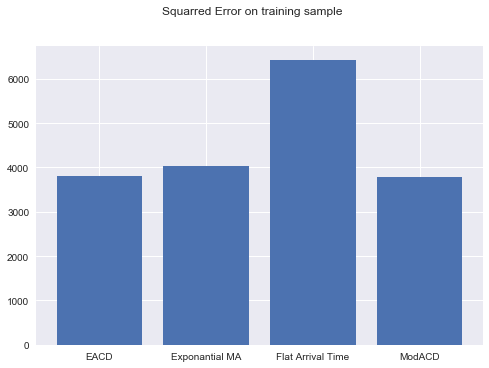

In [31]:
dataToPlot = {'Flat Arrival Time': res_bench1_10, 'Exponantial MA': res_bench2_10.fun, 'EACD': res_bench3_10.fun, 'ModACD': res_ModACD_10.fun}
names = list(dataToPlot.keys())
values = list(dataToPlot.values())

fig, axs = plt.subplots()
axs.bar(names, values)
fig.suptitle('Squarred Error on training sample')

plt.show()

The squared errors for the flat arrival time is : 1495.60797233 



C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in multiply
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in multiply


The squared errors for the flat arrival time is : 873.8188831597189  with best solution x:  [ 0.94570252]


C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


     fun: 844.559959867694
     jac: array([ 0.01094818, -0.00295258,  0.01298523,  0.00439453, -0.00365448,
        0.01296997,  0.00526428, -0.01263428,  0.05162048,  0.22637177,
       -0.01592255])
 message: 'Optimization terminated successfully.'
    nfev: 1162
     nit: 84
    njev: 84
  status: 0
 success: True
       x: array([ 0.02887992, -0.16353832,  0.58664748, -2.4341623 ,  0.10000169,
       -0.49625366,  2.48191751, -0.65225898,  0.98727143,  0.0259041 ,
        0.63498775])


C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


     fun: 817.6197391491476
     jac: array([  5.34057617e-05,  -5.03540039e-04,  -7.62939453e-06,
        -3.58581543e-04,  -5.03540039e-04,  -8.39233398e-05,
         3.05175781e-05,   2.73895264e-03,  -1.16729736e-03,
        -1.39617920e-03,  -1.73187256e-03,   3.19122314e-01,
        -4.26208496e-01,   4.24743652e-01,   8.24127197e-02])
 message: 'Optimization terminated successfully.'
    nfev: 658
     nit: 36
    njev: 36
  status: 0
 success: True
       x: array([  1.79374305e+01,   5.67828707e-01,   1.15729673e+00,
         2.32933613e+00,   3.15972402e+00,   3.14198624e+00,
         2.74257267e+00,  -5.22335125e-02,  -3.24979830e-01,
        -6.13033107e-01,  -7.51685441e-01,   3.08186615e-03,
         6.75184431e-03,   4.79858368e-03,   4.39004628e-03])


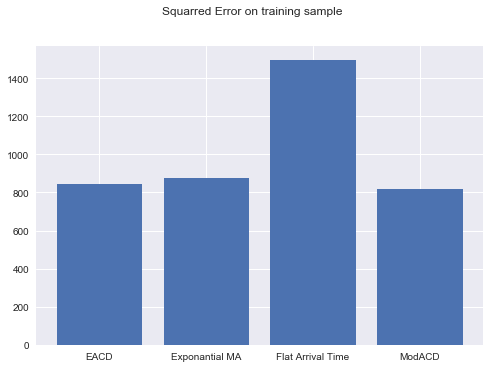

In [33]:
#testing on different window
with gzip.open('data\\2017.11.01\\feeddata_09.json.gz', "rb") as f:
    data2017110109 = json.loads(f.read().decode("ascii"))
    
myDataForRun = extractInterestingData(nbOfDataPoints,'335',data2017110109)

#benchmark 1 : next tick arrives at same pace as the last
res_bench1 = residualSamePace()
print("The squared errors for the flat arrival time is :",res_bench1, "\n")
#benchmark 2 : next tick arrives at an exponential moving average of the last infos with fitted param
res_bench2 = optimize.minimize(residualExpoMovingAverage,[1], method='SLSQP', options={'maxiter':30000})
print("The squared errors for the expo arrival time is :", res_bench2.fun, " with best solution x: ", res_bench2.x)

#benchmark 3 : next tick arrives with EACD model
res_bench3 = optimize.minimize(residualTotalEACD,initParams(True,False),args=(initParams(True,True)), method='SLSQP', options={'maxiter':30000})
print(res_bench3)
res_ModACD = optimize.minimize(residualTotalModACD,initParams(False,False),args=(initParams(False,True)), method='SLSQP', options={'maxiter':30000})
print(res_ModACD)

dataToPlot = {'Flat Arrival Time': res_bench1, 'Exponantial MA': res_bench2.fun, 'EACD': res_bench3.fun, 'ModACD': res_ModACD.fun}
names = list(dataToPlot.keys())
values = list(dataToPlot.values())

fig, axs = plt.subplots()
axs.bar(names, values)
fig.suptitle('Squarred Error on training sample')

plt.show()

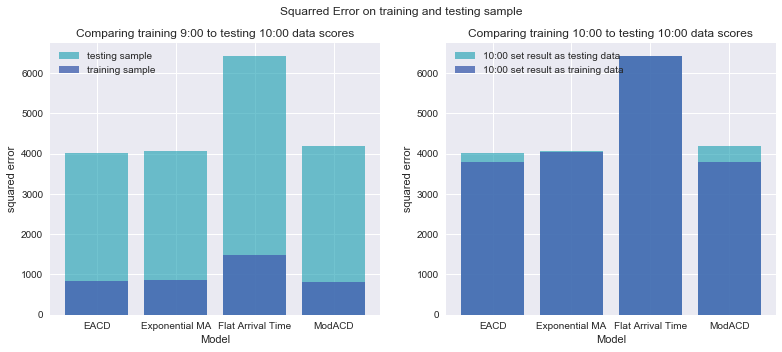

In [36]:
#let's test the data trained on 10am on the 09am set
myDataForRun = extractInterestingData(nbOfDataPoints,'335',data2017110110)

residualSamePace()

dataToPlot1 = {'Flat Arrival Time': residualSamePace(), 'Exponential MA': residualExpoMovingAverage(res_bench2.x), 'EACD': residualTotalEACD(res_bench3.x,initParams(True,True)), 'ModACD': residualTotalModACD(res_ModACD.x,initParams(False,True))}
names1 = list(dataToPlot1.keys())
values1 = list(dataToPlot1.values())

dataToPlot2 = {'Flat Arrival Time': res_bench1, 'Exponential MA': res_bench2.fun, 'EACD': res_bench3.fun, 'ModACD': res_ModACD.fun}
names2 = list(dataToPlot2.keys())
values2 = list(dataToPlot2.values())

dataToPlot3 = {'Flat Arrival Time': res_bench1_10, 'Exponential MA': res_bench2_10.fun, 'EACD': res_bench3_10.fun, 'ModACD': res_ModACD_10.fun}
names3 = list(dataToPlot3.keys())
values3 = list(dataToPlot3.values())

fig, axs = plt.subplots(1, 2, figsize=(13, 5))
axs[0].bar(names1, values1, color = "#139caf", alpha = 0.6, label = "testing sample")
axs[0].bar(names2,values2, color = '#4563b0', alpha = 0.8, label = "training sample")
axs[0].set_ylabel("squared error")
axs[0].set_xlabel("Model")
axs[0].set_title("Comparing training 9:00 to testing 10:00 data scores")
axs[0].legend(loc = 'upper left')

axs[1].bar(names1,values1, color = "#139caf" , alpha = 0.6, label = "10:00 set result as testing data")
axs[1].bar(names3, values3, color ='#4563b0' , alpha = 0.8, label = "10:00 set result as training data")
axs[1].set_ylabel("squared error")
axs[1].set_xlabel("Model")
axs[1].set_title("Comparing training 10:00 to testing 10:00 data scores")
axs[1].legend(loc = 'upper left')



fig.suptitle('Squarred Error on training and testing sample')

plt.show()

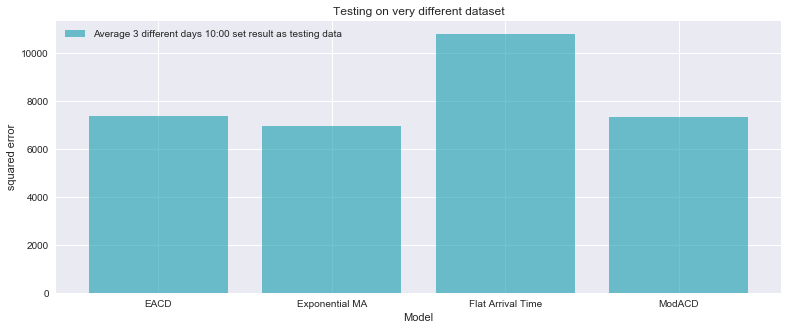

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(13, 5))

ax.bar(['EACD','Exponential MA', 'Flat Arrival Time', 'ModACD'],[7348.6,6963.1,10785.3,7307.1], color = "#139caf" , alpha = 0.6, label = "Average 3 different days 10:00 set result as testing data")
ax.set_ylabel("squared error")
ax.set_xlabel("Model")
ax.set_title("Testing on very different dataset")
ax.legend(loc = 'upper left')
plt.show()

#### We can see that the testing sample has naturally more variance than the training sample (Flat Arrival Time is not being trained). We can however see that the EACD and Mod ACD fail to be very performant in comparison with a simpler model (exponential MA).

In [84]:
result = pd.DataFrame()
paramLearn = pd.DataFrame()
justEACDParam = pd.DataFrame()

In [90]:
#testing on different window
# # result = pd.DataFrame()
# paramLearn = pd.DataFrame()
for i in range(1,31):
    if i<10:
        myDay = "0"+str(i)
    else:
        myDay = str(i)
    myFile = Path('data\\2017.04.'+myDay+'\\feeddata_10.json.gz')
    if myFile.exists():
        with gzip.open('data\\2017.04.'+myDay+'\\feeddata_10.json.gz', "rb") as f:
            datatemp = json.loads(f.read().decode("ascii"))

        myStrike = whichStrikeAtMoney(datatemp)
        print(myStrike)
        myDataForRun = extractInterestingData(nbOfDataPoints,str(myStrike),datatemp)

        #benchmark 1 : next tick arrives at same pace as the last
        res_bench1 = residualSamePace()
    #     print("The squared errors for the flat arrival time is :",res_bench1, "\n")
        #benchmark 2 : next tick arrives at an exponential moving average of the last infos with fitted param
#          res_bench2 = optimize.minimize(residualExpoMovingAverage,[1], method='SLSQP', options={'maxiter':30000})
    #     print("The squared errors for the flat arrival time is :", res_bench2.fun, " with best solution x: ", res_bench2.x)

        #benchmark 3 : next tick arrives with EACD model
        res_bench3 = optimize.minimize(residualTotalEACD,initParams(True,False),args=(initParams(True,True)), method='SLSQP', options={'maxiter':30000})
    #     print(res_bench3)
    
#         res_ModACD = optimize.minimize(residualTotalModACD,initParams(False,False),args=(initParams(False,True)), method='SLSQP', options={'maxiter':30000})

#     print(res_ModACD)

    #     dataToPlot = {'Flat Arrival Time': res_bench1, 'Exponential MA': res_bench2.fun, 'EACD': res_bench3.fun, 'ModACD': res_ModACD.fun}
    #     names = list(dataToPlot.keys())
    #     values = list(dataToPlot.values())

    #     fig, axs = plt.subplots()
    #     axs.bar(names, values)
    #     fig.suptitle('Squarred Error on training sample')

    #     plt.show()
#         s0 = pd.Series([res_bench1], name='Flat Arrival')
# #         s1 = pd.Series([res_bench2.fun], name='Exponential')
#         s2 = pd.Series([res_bench3.fun], name='EACD')
# #         s3 = pd.Series([res_ModACD.fun], name='ModACD')

# #         dfTemp = pd.concat([s0, s1, s2, s3], axis=1)

# #         result = pd.concat([result, dfTemp], axis=0, ignore_index=True)

#         p0 = pd.Series([1], name='Flat Arrival')
# #         p1 = pd.Series(res_bench2.x, name='Exponential')
#         p2 = pd.Series([res_bench3.x], name='EACD')
# #         p3 = pd.Series([res_ModACD.x], name='ModACD')

#         dfTemp2 = pd.concat([p0, p1, p2, p3], axis=1)

        paramLearn = pd.concat([paramLearn, dfTemp2], axis=0, ignore_index=True)
        
        justEACDParam = pd.concat([justEACDParam,pd.DataFrame([np.append(np.array(res_bench3.fun), res_bench3.x)], columns=["Result"]+["Param"+str(x) for x in range(11)])], axis=0, ignore_index=True)

285


C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


280
280
280
280
280
275
275
275
280
280
280
275
275
280
280
280
285
285
290


In [91]:
writer = pd.ExcelWriter('ACDResults/ACDParam3.xlsx')
justEACDParam.to_excel(writer)
writer.save()

In [87]:
writer = pd.ExcelWriter('ACDResults/res2.xlsx')
result.to_excel(writer)
writer.save()

In [88]:
writer = pd.ExcelWriter('ACDResults/fullParam2.xlsx')
paramLearn.to_excel(writer)
writer.save()

Now we can cluster the parameters into different groups; observe the mean performance of each group, test the grouped parameters (mean or different way) on the whole period : observe results robustess

In [112]:
paramsAndRes = pd.read_excel('ACDResults/ACDParam2.xlsx')

In [113]:
print('we can observe a huge sampling variance')
paramsAndRes.describe()


we can observe a huge sampling variance


,Result,Param0,Param1,Param2,Param3,Param4,Param5,Param6,Param7,Param8,Param9,Param10
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,18618.958546,3.704431,-1.814131,-4.702837,-4.378437,0.098395,3.646845,14.735283,0.270045,0.291025,-0.007411,0.217315
std,17683.636779,11.917863,2.567678,8.553583,10.927614,11.403764,12.013216,7.666806,0.619508,0.587390,0.749377,0.715598
min,1170.075506,-6.992713,-6.811045,-24.677599,-29.070796,-31.462696,-17.676560,4.258616,-0.838769,-0.516247,-1.507240,-1.670326
25%,7281.790639,-0.068188,-3.538654,-8.392216,-10.276610,-1.858686,-0.165519,9.227618,-0.321408,-0.221780,-0.307535,-0.178850
50%,11376.666822,0.557017,-1.771026,-4.819455,-0.762834,1.668571,3.463200,13.080508,0.473982,0.196918,-0.083551,0.126731
75%,27137.676751,3.795064,0.099715,0.669893,2.089098,7.222950,6.508157,18.178143,0.842402,0.657220,0.104124,0.556055
max,78712.229266,64.547790,3.464559,13.743029,19.893579,15.946976,39.464287,38.166987,0.955118,1.583442,1.564394,1.701618


### Once we have performed a benchmark on the training set, we need to compare the benchmarks on a testing set
# Then we perform statistical tests on the soundness/robustness of our measures. 

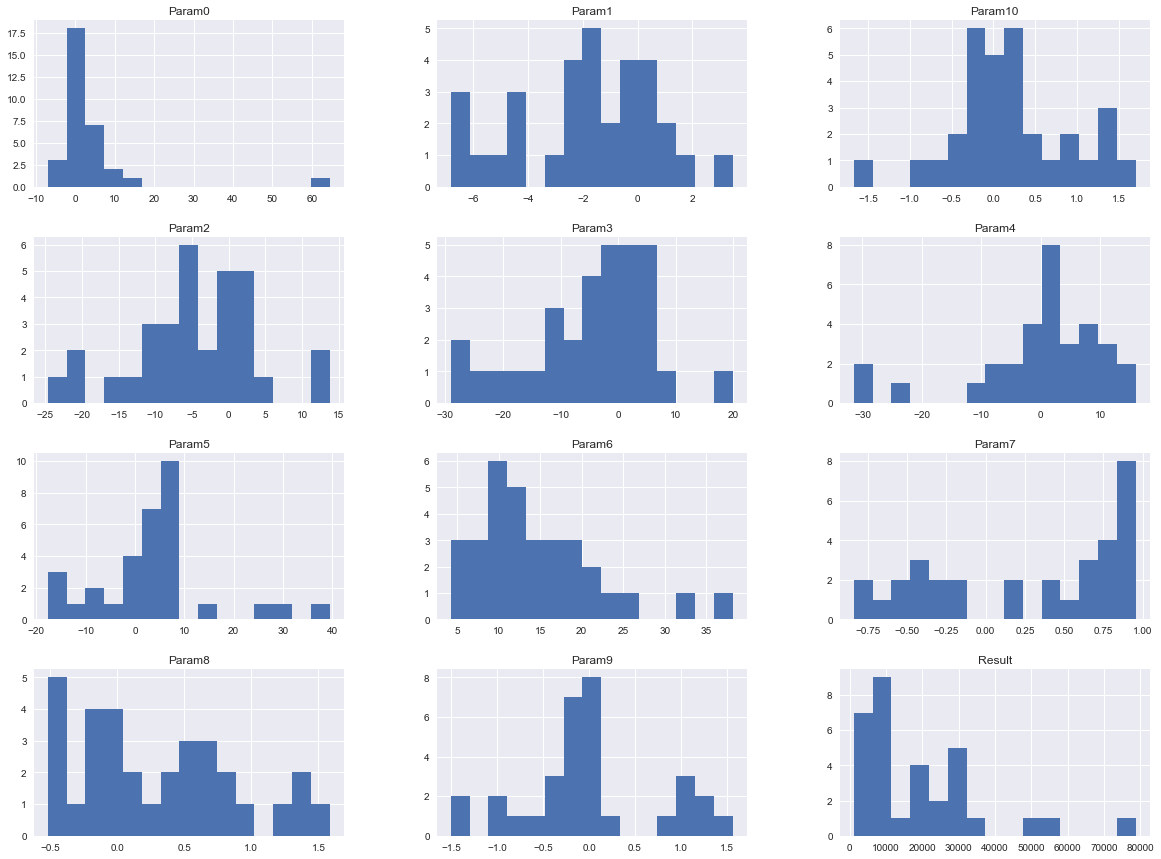

In [114]:

paramsAndRes.hist(bins=15,figsize=(20,15))
plt.show()

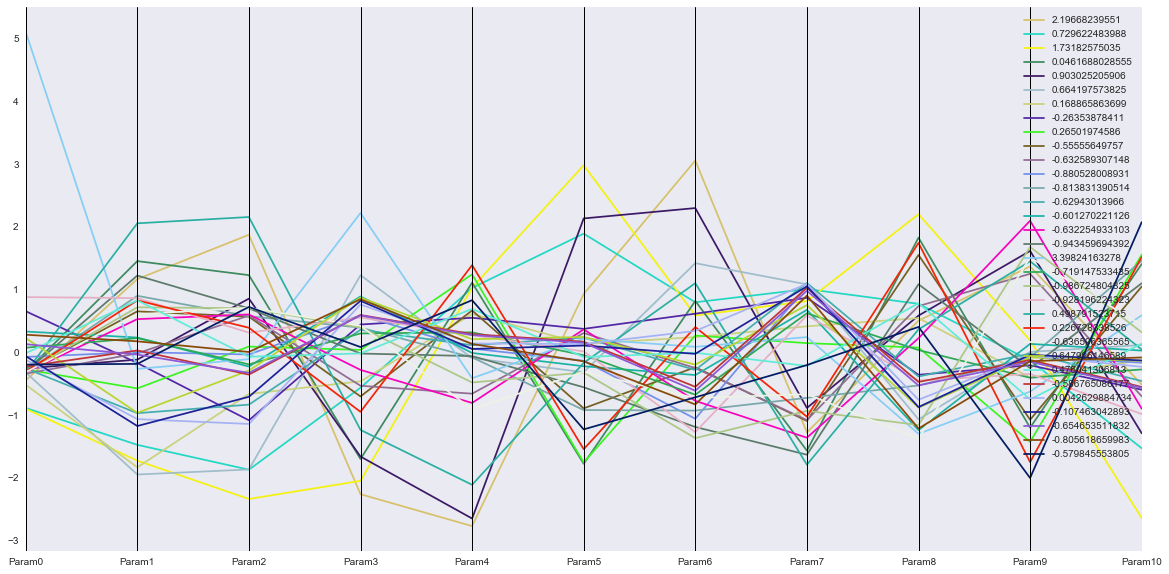

In [115]:

plt.figure(figsize=(20,10))

parallel_coordinates(((paramsAndRes-paramsAndRes.mean())/paramsAndRes.std()), "Result")
plt.show()

In [116]:

for n in range(2, 20):
   
    
    clusterer = GMM(n_components=n, random_state=11)

    clusterer.fit(paramsAndRes.drop('Result', axis = 1))

    preds = clusterer.predict(paramsAndRes.drop('Result', axis = 1))

    centers = clusterer.means_

    
    score = silhouette_score(paramsAndRes.drop('Result', axis = 1), preds, random_state=1)
    print('GMM silhouette score for {} clusters is {}'.format(n,score))

GMM silhouette score for 2 clusters is 0.4952960016087231
GMM silhouette score for 3 clusters is 0.4972239853365957
GMM silhouette score for 4 clusters is 0.15736291964888852
GMM silhouette score for 5 clusters is 0.21184018355216683
GMM silhouette score for 6 clusters is 0.35598900225393165
GMM silhouette score for 7 clusters is 0.29700928750618116
GMM silhouette score for 8 clusters is 0.28839940002358555
GMM silhouette score for 9 clusters is 0.27172366788069535
GMM silhouette score for 10 clusters is 0.24735318561772407
GMM silhouette score for 11 clusters is 0.2233757560817754
GMM silhouette score for 12 clusters is 0.20457285697938293
GMM silhouette score for 13 clusters is 0.20666687993670896
GMM silhouette score for 14 clusters is 0.2209227645178283
GMM silhouette score for 15 clusters is 0.18558940512024938
GMM silhouette score for 16 clusters is 0.18667486615371676
GMM silhouette score for 17 clusters is 0.19225177136872174
GMM silhouette score for 18 clusters is 0.1762368852

In [117]:

for n in range(2, 20):
    
    clusterer = KMeans(n_clusters=n, random_state=11)

    clusterer.fit(paramsAndRes.drop('Result', axis = 1))

    preds = clusterer.predict(paramsAndRes.drop('Result', axis = 1))

    centers = clusterer.cluster_centers_

    from sklearn.metrics import silhouette_score
    score = silhouette_score(paramsAndRes.drop('Result', axis = 1), preds, random_state=1)
    print('KMean silhouette score for {} clusters is {}'.format(n,score))

KMean silhouette score for 2 clusters is 0.4952960016087231
KMean silhouette score for 3 clusters is 0.5162077046294841
KMean silhouette score for 4 clusters is 0.5222796107404695
KMean silhouette score for 5 clusters is 0.42229580182365384
KMean silhouette score for 6 clusters is 0.35598900225393165
KMean silhouette score for 7 clusters is 0.29700928750618116
KMean silhouette score for 8 clusters is 0.28033355536329096
KMean silhouette score for 9 clusters is 0.26207376631882195
KMean silhouette score for 10 clusters is 0.22056759791643754
KMean silhouette score for 11 clusters is 0.2569111033402232
KMean silhouette score for 12 clusters is 0.2381082042378307
KMean silhouette score for 13 clusters is 0.2480777120919751
KMean silhouette score for 14 clusters is 0.20900686093341908
KMean silhouette score for 15 clusters is 0.21547545367279164
KMean silhouette score for 16 clusters is 0.2144777910210969
KMean silhouette score for 17 clusters is 0.18517281101817434
KMean silhouette score 

Given both results, let's take 3 clusters with GMM (more diversity of results, more robust too)

In [118]:
clusterer = KMeans(n_clusters=3, random_state=11)

clusterer.fit(paramsAndRes.drop('Result', axis = 1))
   
preds = clusterer.predict(paramsAndRes.drop('Result', axis = 1))

centers = clusterer.cluster_centers_

score = silhouette_score(paramsAndRes.drop('Result', axis = 1), preds, random_state=1)
print('GMM silhouette score for {} clusters is {}'.format(n,score))

preds

GMM silhouette score for 19 clusters is 0.5162077046294841


array([0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2])

In [119]:
paramsAndRes = pd.concat([paramsAndRes, pd.DataFrame(pd.Series(preds, name='cluster'))],axis=1)

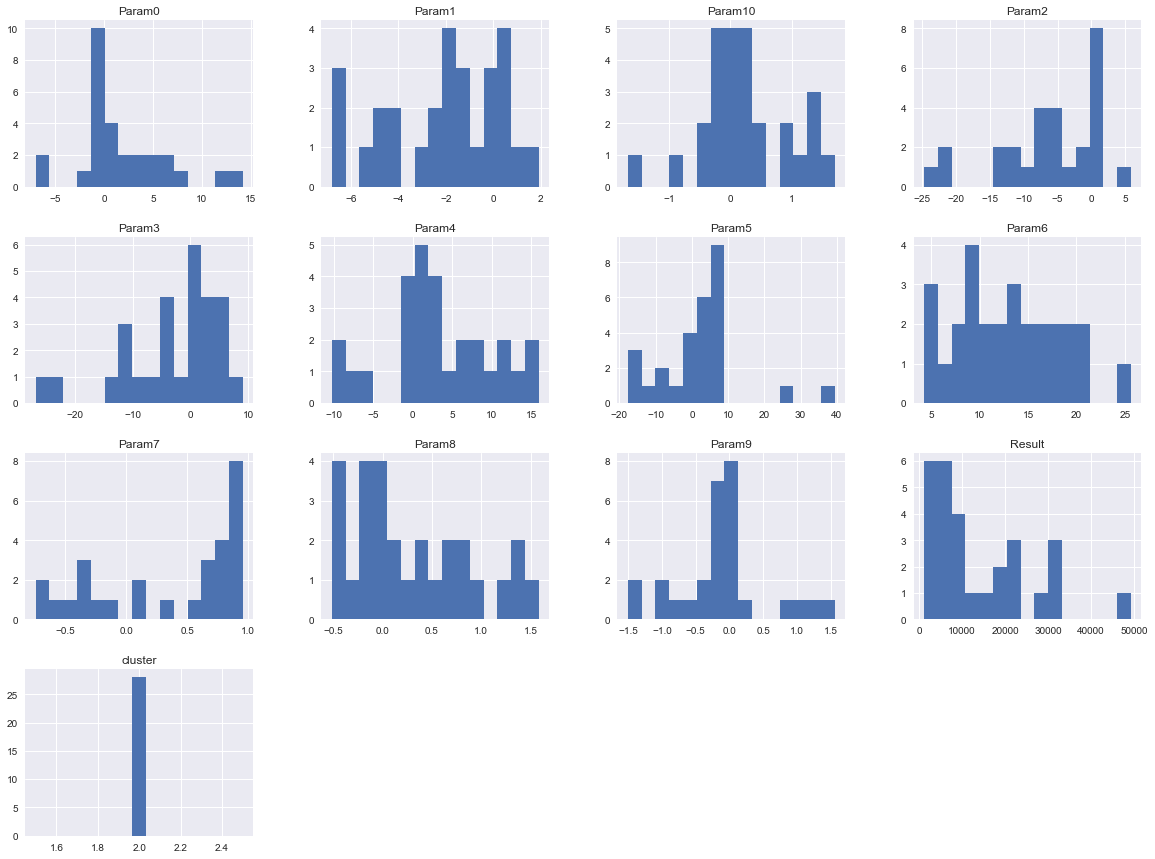

In [120]:

paramsAndRes[paramsAndRes['cluster']==2].hist(bins=15,figsize=(20,15))
plt.show()

In [121]:
paramsAndRes.groupby(['cluster']).describe().Result

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,3.0,39830.475705,15684.012151,27439.406680,31013.567485,34587.728289,46026.010218,57464.292146
1,1.0,78712.229266,NaN,78712.229266,78712.229266,78712.229266,78712.229266,78712.229266
2,28.0,14200.107754,11697.330299,1170.075506,6757.181414,8303.999137,21860.925891,49243.936079


We need to check upthere if the cluster make sense : look at the std deviation of each param, is it too high ? is there a too big min-max distance for each param to take the mean ?

In [122]:
(paramsAndRes.drop('Result', axis = 1).groupby(['cluster']).max()-paramsAndRes.drop('Result', axis = 1).groupby(['cluster']).min()).sum(axis = 1)

cluster
0     82.121046
1      0.000000
2    211.154924
dtype: float64

In [124]:
newParams = []
for i in range(0,11):
    newParams.append(paramsAndRes.groupby(['cluster']).mean()['Param'+str(i)][0])

In [126]:
resACDMod = []
resExpo = []

for i in range(1,31):
    if i<10:
        myDay = "0"+str(i)
    else:
        myDay = str(i)
    myFile = Path('data\\2017.04.'+myDay+'\\feeddata_12.json.gz')
    if myFile.exists():
        with gzip.open('data\\2017.04.'+myDay+'\\feeddata_12.json.gz', "rb") as f:
            datatemp = json.loads(f.read().decode("ascii"))

        myStrike = whichStrikeAtMoney(datatemp)
        print(myStrike)
        myDataForRun = extractInterestingData(nbOfDataPoints,str(myStrike),datatemp)
        resACDMod.append(residualTotalEACD(newParams,initParams(False,True)))
        resExpo.append(residualExpoMovingAverage(0.89))

280
280
280
280
280
275
275
275
275
280
280
280
275
280
280
280
285
285
285
290


In [127]:
print(np.mean(resACDMod))
print(np.mean(resExpo))

30125.2816017
24411.9562105


It seems we cannot perform good clustering, which is more evidence against the robustness of these paramters. Indeed, we could have hoped to find that several sets of parameters are global minima close to a global maximum, and thus, the optimizer can give different sets of optimizer when trained over different set of data. But it seems that parameters are quite far from each others and we cannot even cluster them correctly.

In [130]:
newParams2 = paramsAndRes[paramsAndRes['cluster']==0][paramsAndRes['Result'] == np.min(paramsAndRes[paramsAndRes['cluster']==0]['Result'])].drop('Result', axis = 1).drop('cluster', axis = 1).values

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [131]:
resACDMod2 = []
resExpo2 = []

for i in range(1,31):
    if i<10:
        myDay = "0"+str(i)
    else:
        myDay = str(i)
    myFile = Path('data\\2017.04.'+myDay+'\\feeddata_12.json.gz')
    if myFile.exists():
        with gzip.open('data\\2017.04.'+myDay+'\\feeddata_12.json.gz', "rb") as f:
            datatemp = json.loads(f.read().decode("ascii"))

        myStrike = whichStrikeAtMoney(datatemp)
        print(myStrike)
        myDataForRun = extractInterestingData(nbOfDataPoints,str(myStrike),datatemp)
        resACDMod2.append(residualTotalEACD(newParams2,initParams(False,True)))
        resExpo2.append(residualExpoMovingAverage(0.89))

280
280
280
280
280
275
275
275
275
280
280
280
275
280
280
280
285
285
285
290


In [132]:
print(np.mean(resACDMod2))
print(np.mean(resExpo2))

45266.5664018
24411.9562105


# III. Exploratory Analysis :
What is the distribution of waiting time ?
What is the average waiting time for each time frame of the day ?
What is the sampling variance like ?
Is it changing a lot from day to day or is there consistencies ?

In [137]:
def extractOptionData(nbOfDataPoints_, aOptionStrike, data_):
    myTicksOfInterest = []
    myCounter = 0
    firstOpt= True
    myOptBook = ""
    
    for idx, tick in enumerate(data_):
        myBook =tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
            if tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):

                if firstOpt :
                    myOptBook = myBook
                    firstOpt = False
                    
                if myOptBook==myBook:   
                            myCounter = myCounter + 1
                            myTicksOfInterest.append({
                                             'received': utcToRightTMZ(datetime.utcfromtimestamp(tick['received']/1000000)),
                                             'created' : utcToRightTMZ(datetime.utcfromtimestamp(tick['created']/1000000))
                                            })

        if myCounter >= nbOfDataPoints_:
            break
    return myTicksOfInterest

In [138]:
optionData = pd.DataFrame(extractOptionData(200000,335,data2017110110))

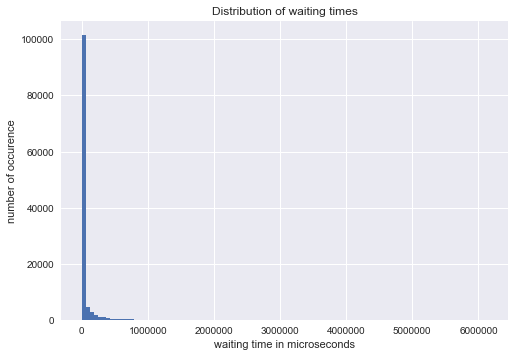

In [139]:
(optionData - optionData.shift())['created'].astype('timedelta64[us]').hist(bins=100)
plt.title("Distribution of waiting times")
plt.ylabel('number of occurence')
plt.xlabel('waiting time in microseconds')
plt.show()

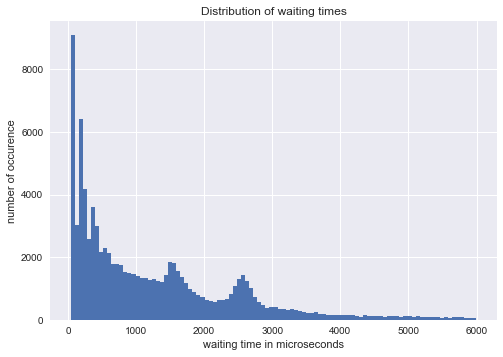

In [140]:
#closer look
dif = (optionData - optionData.shift()).astype('timedelta64[us]')
dif[dif['created']<6000]['created'].hist(bins=100)
plt.title("Distribution of waiting times")
plt.ylabel('number of occurence')
plt.xlabel('waiting time in microseconds')
plt.show()

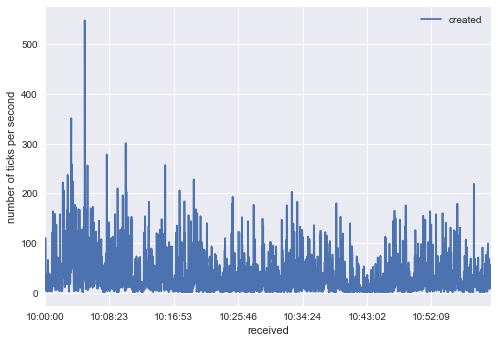

In [141]:
optionData2 = optionData.copy()
optionData2['received'] = optionData2['received'].apply(dt.date.strftime, args=('%H:%M:%S',))

(optionData2.set_index('received')-optionData2.set_index('received').shift()).groupby(['received']).count().plot()
plt.ylabel('number of ticks per second')
plt.show()
#optionData2 = optionData2.mean(axis=1)

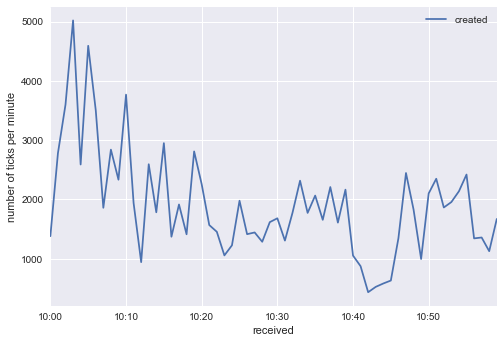

In [142]:
optionData2 = optionData.copy()
optionData2['received'] = optionData2['received'].apply(dt.date.strftime, args=('%H:%M',))

(optionData2.set_index('received')-optionData2.set_index('received').shift()).groupby(['received']).count().plot()
plt.ylabel('number of ticks per minute')
plt.show()

In [143]:
with gzip.open('data\\2017.11.01\\feeddata_13.json.gz', "rb") as f:
    data2017110113 = json.loads(f.read().decode("ascii")) 

In [144]:
optionData13 = pd.DataFrame(extractOptionData(200000,335,data2017110113))

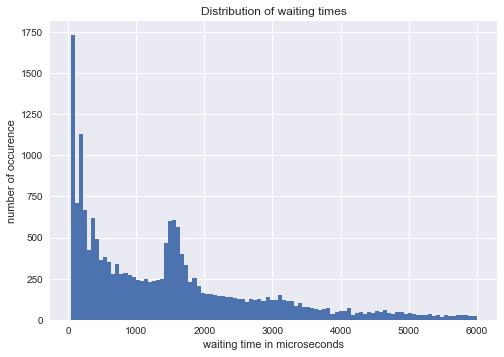

In [145]:
#closer look
dif13 = (optionData13 - optionData13.shift()).astype('timedelta64[us]')
dif13[dif13['created']<6000]['created'].hist(bins=100)
plt.title("Distribution of waiting times")
plt.ylabel('number of occurence')
plt.xlabel('waiting time in microseconds')
plt.show()

A few interesting phenomena to investigate : what is this spike of occurences at 1.5ms for both hours?  It happens for both timeframes. 
Also, the market looks less busy at 13:00 than at 10:00. It makes sense.

In [146]:
def residualExpoMovingAverage13(aParam) : 
    errs = []
    first = True
    counter = 0
    for idx, tick in enumerate(extractOptionData(200000,335,data2017110113)):
        counter = counter + 1
        try:
            
            if not first:
                ArrivalTime = (tick["created"]-myFormerTime).microseconds/1000
                errs.append((ArrivalTime - ExpectedTime)*(ArrivalTime - ExpectedTime))
                myFormerTime = tick["created"]
                ExpectedTime = aParam*ExpectedTime +(1-aParam)*ArrivalTime
            else:
                if counter  == 2:
                    ExpectedTime = (tick["created"]-myFormerTime).microseconds/1000
                    first = False
            myFormerTime = tick["created"]
        except KeyError:
            print(tick)
            
    return np.mean(errs)

In [147]:
residualExpoMovingAverage13(res_bench2.x)

24900.78139713957

In [148]:
res_bench_test = optimize.minimize(residualExpoMovingAverage13,[res_bench2.x], method='SLSQP', options={'maxiter':30000})

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in multiply
  del sys.path[0]


In [149]:
print(res_bench_test)

     fun: 24495.02371535383
     jac: array([-0.1887207])
 message: 'Optimization terminated successfully.'
    nfev: 26
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([ 0.87468379])


In [150]:
print(res_bench2)

     fun: 9272.742417483243
     jac: array([ 0.00061035])
 message: 'Optimization terminated successfully.'
    nfev: 49
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([ 0.74929525])


#### At first sight the results seem relatively robust, the error is not really different with the version trained on the testing set and the parameter value optimized on the two different sets is not so different. Again, we are just taking a single day with the 10:00-11:00 data as a training set and the 13:00-14:00 data as a testing set.

bigger data analysis

In [151]:
optionDataDay = pd.DataFrame()

for i in range(8,16):
    if i<10:
        stringNumber = '0'+str(i)
    else:
        stringNumber = str(i)
    with gzip.open('data\\2017.11.01\\feeddata_'+stringNumber+'.json.gz', "rb") as f:
        dataTemp = json.loads(f.read().decode("ascii")) 
        optionDataDay =  pd.concat([optionDataDay,pd.DataFrame(extractOptionData(200000,335,dataTemp))])
del dataTemp    
    

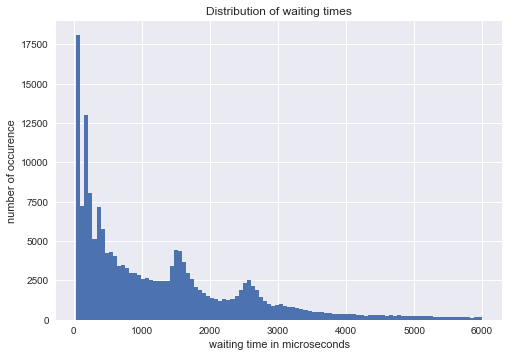

In [152]:
#closer look
difday = (optionDataDay - optionDataDay.shift()).astype('timedelta64[us]')
difday[(difday['created']<6000) & (difday['created']>0)]['created'].hist(bins=100)
plt.title("Distribution of waiting times")
plt.ylabel('number of occurence')
plt.xlabel('waiting time in microseconds')
plt.show()

Interestingly enough, it is very similar to subsets.

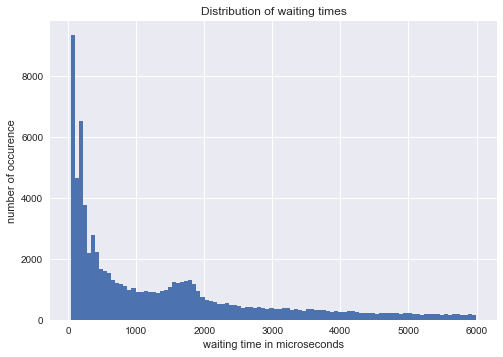

In [153]:
optionDataDay = pd.DataFrame()

for i in range(8,16):
    if i<10:
        stringNumber = '0'+str(i)
    else:
        stringNumber = str(i)
    with gzip.open('data\\2017.11.02\\feeddata_'+stringNumber+'.json.gz', "rb") as f:
        dataTemp = json.loads(f.read().decode("ascii")) 
        optionDataDay =  pd.concat([optionDataDay,pd.DataFrame(extractOptionData(200000,335,dataTemp))])
del dataTemp   

#closer look
difday = (optionDataDay - optionDataDay.shift()).astype('timedelta64[us]')
difday[(difday['created']<6000) & (difday['created']>0)]['created'].hist(bins=100)
plt.title("Distribution of waiting times")
plt.ylabel('number of occurence')
plt.xlabel('waiting time in microseconds')
plt.show()    

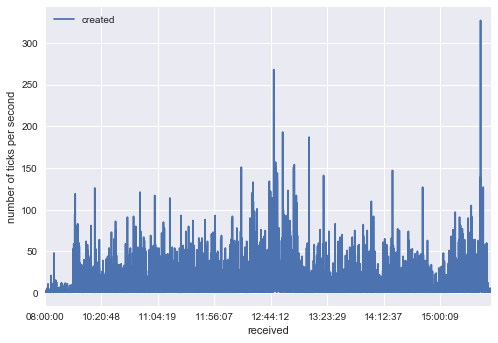

In [154]:
optionDataDay2 = optionDataDay.copy()
optionDataDay2['received'] = optionDataDay2['received'].apply(dt.date.strftime, args=('%H:%M:%S',))
plt.figure(figsize=(20,10))
(optionDataDay2.set_index('received')-optionDataDay2.set_index('received').shift()).groupby(['received']).count().plot()
plt.ylabel('number of ticks per second')
plt.show()

In [57]:
with gzip.open('data\\2017.11.01\\feeddata_10.json.gz', "rb") as f:
    dataTemp = json.loads(f.read().decode("ascii"))
    dataTemp = pd.DataFrame(dataTemp)[(pd.DataFrame(dataTemp)['book']=='KR4201MB3355') & (pd.DataFrame(dataTemp)['type']=='tick')].drop('book', axis=1).drop('price', axis=1).drop('type', axis=1).drop('volume', axis=1).drop('received', axis=1).reset_index()

In [58]:

dataTemp.drop(list(filter(lambda x: ('ask_p' in x) or ('bid_p' in x), dataTemp.columns)), axis=1, inplace=True)

In [70]:
dataTemp['created'] = (dataTemp['created']/1000000).apply(lambda x: datetime.utcfromtimestamp(x))

In [72]:
dataTemp['created'] = dataTemp['created'].apply(lambda x: utcToRightTMZ(x))

In [73]:
dataTemp['created'] = dataTemp['created'].apply(dt.date.strftime, args=('%H:%M:%S',))
dataTemp.set_index('created', inplace=True)
dataTemp.drop('index', axis=1, inplace=True)

In [84]:
dataTemp = (dataTemp- dataTemp.shift())

In [102]:
dataTemp = dataTemp[(dataTemp!=0).apply(np.sum, axis=1)==1]

In [104]:
dataTemp = dataTemp.groupby(['created']).mean()

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


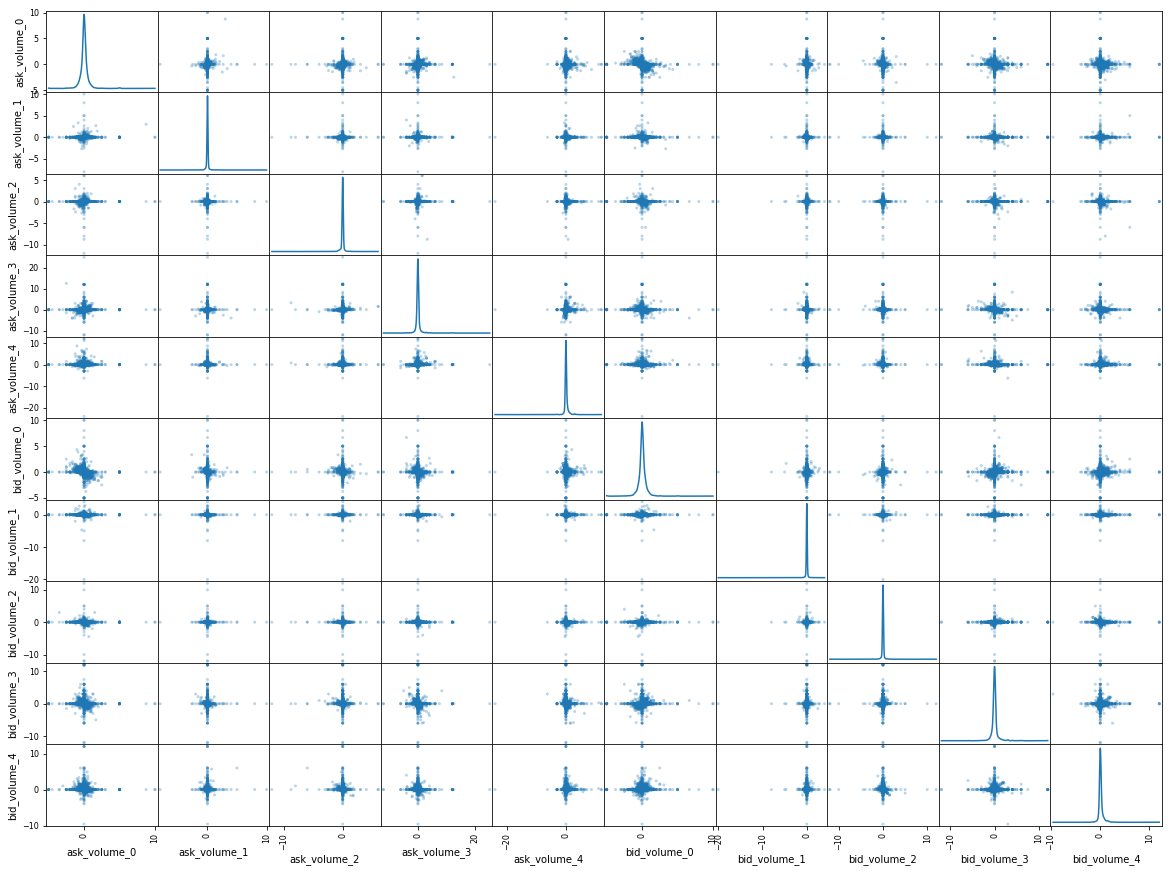

In [110]:
pd.scatter_matrix(dataTemp, alpha = 0.3, figsize = (20,15), diagonal = 'kde')
plt.show()

In [ ]:
#we can add a few things in modACD : binary data of "does the midprice changed" 

# TensorFlow 

We need to rewrite the loss function to work with tensorflow. It is good as it enables me to have easy GPU computation power and potential strong ML tools.

In [39]:
#imports
import tensorflow as tf

if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()

We need to format all our data beforehand, the same way we did before, so for a first try, we can use : myDataForRun
However, the data wasn't fully formatted, as the values we are trying to learn are not yet calculated. Additionally, tensorflow requires to be in a numpy array format:
Let's first calculate them, we will need to slighly change our functions : 

In [91]:
def extractInterestingData(nbOfDataPoints_, aOptionStrike,data_):
    myTicksOfInterest = np.empty(shape = (0,0))
    myCounter = 0
     
        
    myFirstOpt = True
    myOptionBook = ""
    myFutBook = ''
    myFirstFut = True
    
    for idx, tick in enumerate(data_):
        myBook =tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
#             if tick['type']=='lastdone' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE: 
#                 if myFirstFut:
#                     myFutBook = myBook
#                     myFirstFut = False
                    
#                 if myFutBook == myBook:
#                     myTicksOfInterest.append({'contractType' : CONTRACTTYPE.FUTURE,
#                                          'type' : 'lastdone',
#                                          'volume' : tick['volume'],
#                                          'created' : datetime.utcfromtimestamp(tick['created']/1000000)
#                                         })
                
#             elif tick['type']=='lastdone' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
#                     if myFirstOpt:
#                         myOptionBook = myBook
#                         myFirstOpt = False
#                     if myOptionBook == myBook:
#                         myTicksOfInterest .append({'contractType' : CONTRACTTYPE.CALL,
#                                          'type' : 'lastdone',
#                                          'volume' : tick['volume'],
#                                          'created' : datetime.utcfromtimestamp(tick['created']/1000000)
#                                         })
                    
            if tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
                    
                    if myFirstOpt:
                        myOptionBook = myBook
                        myFirstOpt = False
                    
                    if myOptionBook == myBook:
                        myCounter = myCounter + 1
                        try:
                            myTicksOfInterest = np.append( myTicksOfInterest,(datetime.utcfromtimestamp(tick['created']/1000000)-oldTime).microseconds/1000 )
                        except Exception as e:
                            print(e)
                            pass #pass, not continue, continue switch to the next itirqtion
                        oldTime = datetime.utcfromtimestamp(tick['created']/1000000)
                    
        if myCounter > nbOfDataPoints_:
            break
    return myTicksOfInterest

def whichStrikeAtMoney(data_):
    for idx, tick in enumerate(data_):
        myBook = tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
            if tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE: 
#                 print(tick)
                return int(5 * np.floor((tick['bid_price_0']+ tick['ask_price_0'])/2/5))

For now, let's only use the same kind of data, to be compared with our models: i.e. only time series or times.

In [383]:
onlyWaitingTime = np.log(extractInterestingData(30000,whichStrikeAtMoney(data),data))

local variable 'oldTime' referenced before assignment


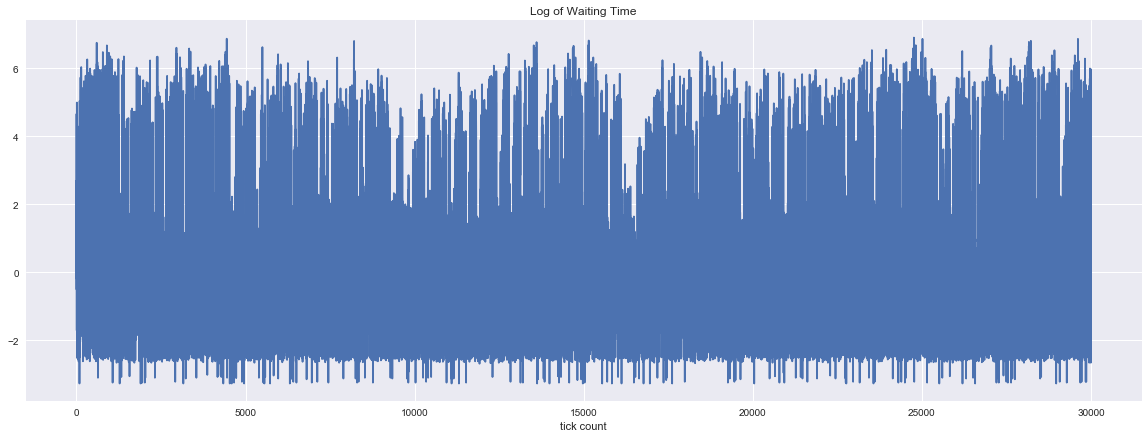

In [384]:
plt.figure(figsize=(20,7))
plt.plot(onlyWaitingTime)
plt.title('Log of Waiting Time')
plt.xlabel('tick count')
plt.show()

In [63]:
tf.reset_default_graph()

In [64]:
def next_batch(data,batch_size,steps,return_index=False):
        
    # Grab a random starting point for each batch
    rand_start = np.random.randint(len(data)-steps, size=(batch_size, 1), dtype = 'int64')

    # Create batch Time Series on occurences (t)
    batch_indices = rand_start + np.arange(0,steps+1)
    
    y_batch = data[batch_indices]

    # Format for RNN
    if return_index:
        return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) ,batch_indices

    else:
        return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

In [65]:
plt.figure(figsize=(20,7))
plt.title("Training vs Target prediction", fontsize=14)
plt.plot(onlyWaitingTime[:-1], "bo", markersize=6,alpha=0.5 ,label="instance")
plt.plot(onlyWaitingTime[1:], "ko", markersize=3, label="target")
plt.legend()
plt.show()

NameError: name 'onlyWaitingTime' is not defined

In [66]:
# Just one feature, the time series
num_inputs = 1
# 100 neuron layer, play with this
num_neurons = 100
# Just one output, predicted time series
num_outputs = 1
# learning rate, 0.0001 default, but you can play with this
learning_rate = 0.00005
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 60000
# Size of the batch of data
batch_size = 500

# Num of steps in batch (also used for prediction steps into the future)
num_time_steps = 50

In [67]:
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])


In [68]:
# cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu)
with tf.name_scope("LSTMcells"):
    n_layers = 4
    lstmCells = [tf.contrib.rnn.LSTMCell(num_units=500, state_is_tuple=True, forget_bias=0.5, reuse=True)]
    lstmCells.extend([tf.contrib.rnn.LSTMCell(num_units=num_neurons, state_is_tuple=True,reuse=True)
          for layer in range(n_layers-1)])
    lstmCells.append(
        tf.contrib.rnn.DropoutWrapper(cell=tf.contrib.rnn.LSTMCell(num_units=num_neurons, state_is_tuple=True,reuse=True), output_keep_prob=0.8))
    
    cell = tf.contrib.rnn.MultiRNNCell(lstmCells)
    outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    
    
with tf.variable_scope("LSTM_V") as vs:
    lstm_variables = []
    for v in tf.all_variables():
        if v.name.startswith("rnn/multi_rnn_cell/"):
#             print(v)
            lstm_variables.append(v)
    for v in lstm_variables:
        tf.summary.histogram(str(v), v)
tf.initialize_variables(lstm_variables)
# cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicRNNCell(num_units=num_neurons)
#           for layer in range(n_layers)])

ValueError: Variable rnn/multi_rnn_cell/cell_0/lstm_cell/weights does not exist, or was not created with tf.get_variable(). Did you mean to set reuse=None in VarScope?

In [406]:
with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
    tf.summary.scalar('loss', loss)
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train = optimizer.minimize(loss)

In [407]:
init = tf.global_variables_initializer()

In [408]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)

In [409]:
saver = tf.train.Saver()

In [411]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    tf.summary.FileWriterCache.clear()
    merged_summary = tf.summary.merge_all()
    writer = tf.summary.FileWriter('C:\\Users\\Hal9000-ti\\ML_MiniProjects\\onlyWaitingTime\\10',graph = sess.graph)  # create writer

    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(onlyWaitingTime, batch_size, num_time_steps)
 
        
        if iteration % 50 == 0:   
            s = sess.run(merged_summary, feed_dict={X: X_batch, y: y_batch})
            writer.add_summary(s,iteration)
        if iteration % 500 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
       
       
       
    # Save Model for Later
    saver.save(sess, "./rnn_time_series_model")
#     writer.add_graph()$
    writer.close()

0 	MSE: 4.48044
500 	MSE: 3.66885
1000 	MSE: 3.76515
1500 	MSE: 3.62972
2000 	MSE: 3.64978
2500 	MSE: 3.47825
3000 	MSE: 3.54932
3500 	MSE: 3.3706
4000 	MSE: 3.59826
4500 	MSE: 3.26013
5000 	MSE: 3.22377
5500 	MSE: 3.29703
6000 	MSE: 3.25953
6500 	MSE: 3.25415
7000 	MSE: 3.37407
7500 	MSE: 3.21081
8000 	MSE: 3.19908
8500 	MSE: 3.0954
9000 	MSE: 3.37285
9500 	MSE: 3.18026
10000 	MSE: 3.23974
10500 	MSE: 3.19295
11000 	MSE: 3.06687
11500 	MSE: 3.07988
12000 	MSE: 3.18699
12500 	MSE: 3.20474
13000 	MSE: 3.26988
13500 	MSE: 3.10017
14000 	MSE: 3.093
14500 	MSE: 3.15481
15000 	MSE: 3.07376
15500 	MSE: 3.10312
16000 	MSE: 3.17253
16500 	MSE: 3.09361
17000 	MSE: 3.08448
17500 	MSE: 3.15476
18000 	MSE: 3.08277
18500 	MSE: 3.07482
19000 	MSE: 3.13234
19500 	MSE: 3.02968
20000 	MSE: 3.03596
20500 	MSE: 3.1839
21000 	MSE: 2.96988
21500 	MSE: 3.17254
22000 	MSE: 3.07938
22500 	MSE: 3.07524
23000 	MSE: 3.10929
23500 	MSE: 3.03507
24000 	MSE: 3.08988
24500 	MSE: 3.17593
25000 	MSE: 3.09665
25500 	MS

In [414]:
# startTime = np.random.randint(len(onlyWaitingTime)-num_time_steps,size=())
# startTime

In [420]:
with tf.Session() as sess:                          
    saver.restore(sess, "./rnn_time_series_model")  
#     saver.save(sess, "./rnn_time_series_model_WaitingTimeOnly")
    X_new = np.array(onlyWaitingTime[:-1][startTime:startTime+num_time_steps].reshape(-1, num_time_steps, num_inputs))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


In [417]:
def residualExpoMovingAverage(aParam) : 
    errs = []
    first = True
    counter = 0
    for idx, waitingTime in enumerate(onlyWaitingTime[:-1]):
            counter = counter + 1
            if not first:
                errs.append((waitingTime - ExpectedTime)*(waitingTime - ExpectedTime))
                ExpectedTime = aParam*ExpectedTime +(1-aParam)*waitingTime
            else:
                if counter  > 2:
                    ExpectedTime = waitingTime
                    first = False
            
    return np.mean(errs[1:])

res_bench2 = optimize.minimize(residualExpoMovingAverage,[1], method='SLSQP', options={'maxiter':30000})
print(res_bench2.fun)

def returnPred(aParam) : 
    pred = []
    first = True
    counter = 0
    ExpectedTime = 0
    for idx, waitingTime in enumerate(onlyWaitingTime[startTime:startTime+num_time_steps][:-1]):

                ExpectedTime = aParam*ExpectedTime +(1-aParam)*waitingTime

                pred.append(ExpectedTime)
            
    return pred


3.6650948878948584


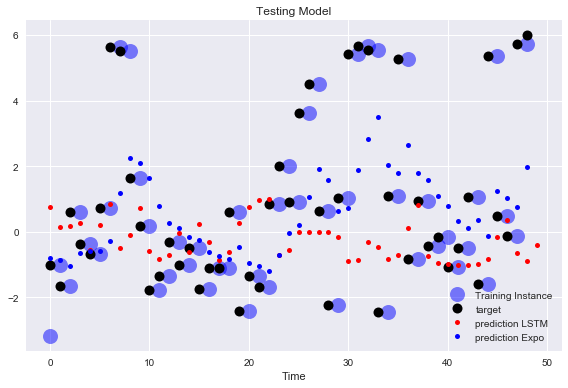

In [421]:
startTime = np.random.randint(len(onlyWaitingTime)-num_time_steps,size=())
plt.title("Testing Model")

# Training Instance
plt.plot(onlyWaitingTime[startTime:startTime+num_time_steps][:-1], "bo", markersize=15,alpha=0.5, label="Training Instance")

# Target to Predict
plt.plot(onlyWaitingTime[startTime:startTime+num_time_steps][1:], "ko", markersize=10, label="target")

# Models Prediction
plt.plot(y_pred[0,:,0], "r.", markersize=10, label="prediction LSTM")

plt.plot(returnPred(res_bench2.x), "b.", markersize=10, label="prediction Expo")
plt.xlabel("Time")
plt.legend()
plt.tight_layout()
plt.show()

In [422]:
def showOtherGraph():
    startTime = np.random.randint(len(onlyWaitingTime)-num_time_steps,size=())

    with tf.Session() as sess:                          
        saver.restore(sess, "./rnn_time_series_model")   
        X_new = np.array(onlyWaitingTime[:-1][startTime:startTime+num_time_steps].reshape(-1, num_time_steps, num_inputs))
        y_pred = sess.run(outputs, feed_dict={X: X_new})

    plt.title("Testing Model")

    # Training Instance
    plt.plot(onlyWaitingTime[startTime:startTime+num_time_steps][:-1], "bo", markersize=15,alpha=0.5, label="Training Instance")

    # Target to Predict
    plt.plot(onlyWaitingTime[startTime:startTime+num_time_steps][1:], "ko", markersize=10, label="target")

    # Models Prediction
    plt.plot(y_pred[0,:,0], "r.", markersize=10, label="prediction LSTM")

    plt.plot(returnPred(res_bench2.x), "b.", markersize=10, label="prediction Expo")
    plt.xlabel("Time")
    plt.legend()
    plt.tight_layout()
    plt.show()

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


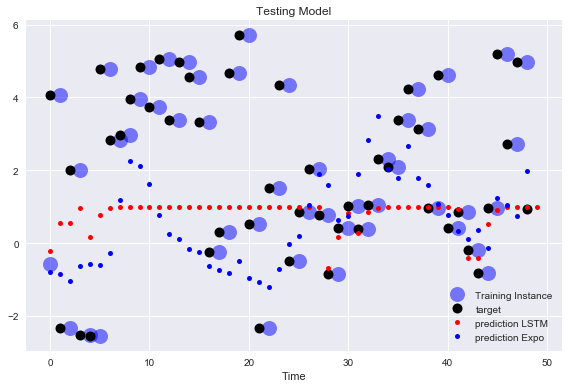

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


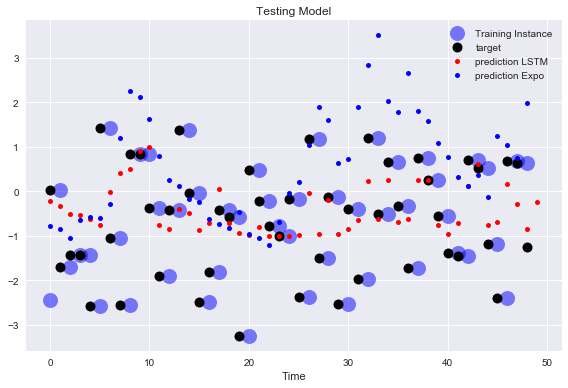

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


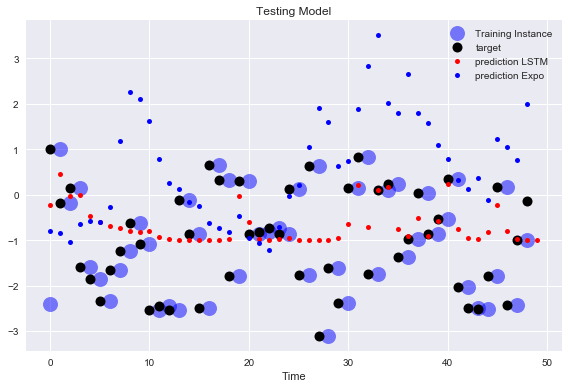

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


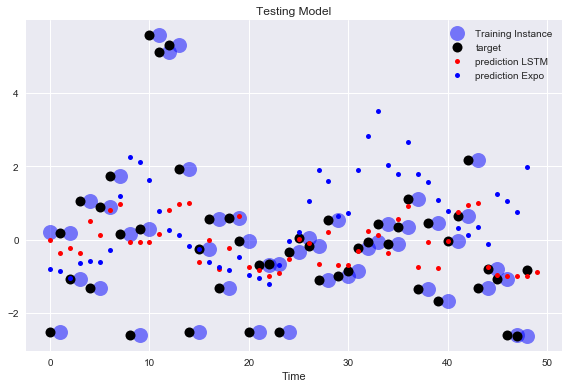

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


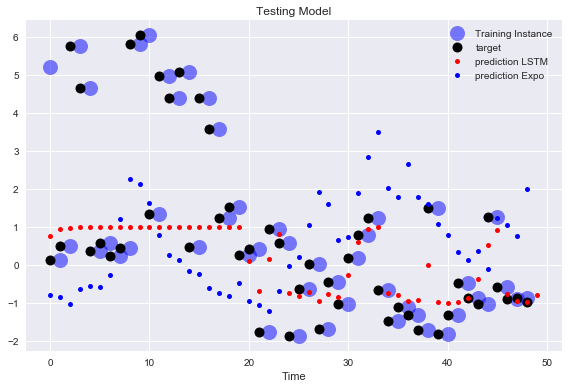

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


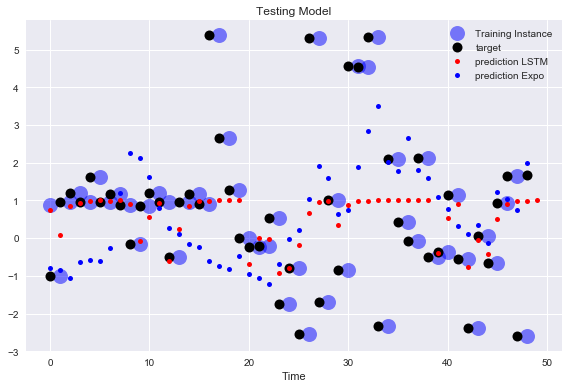

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


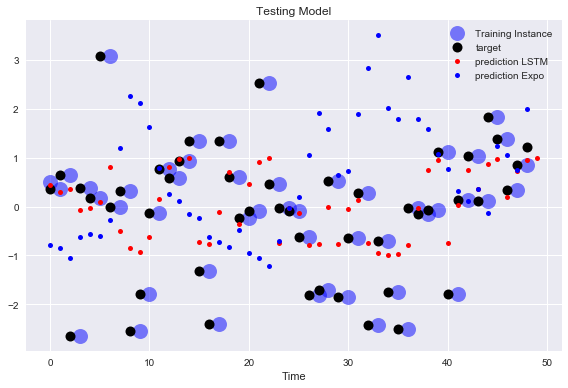

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


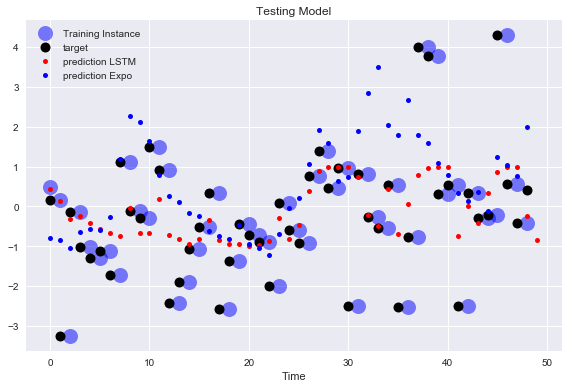

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


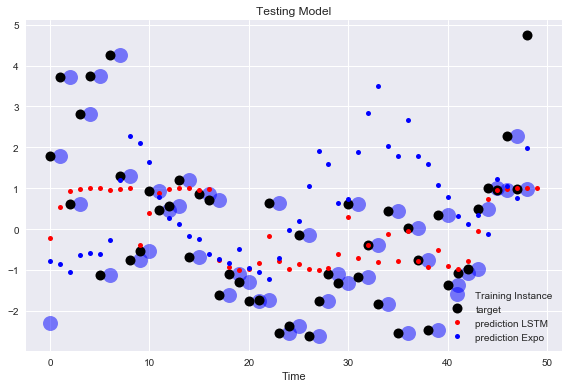

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


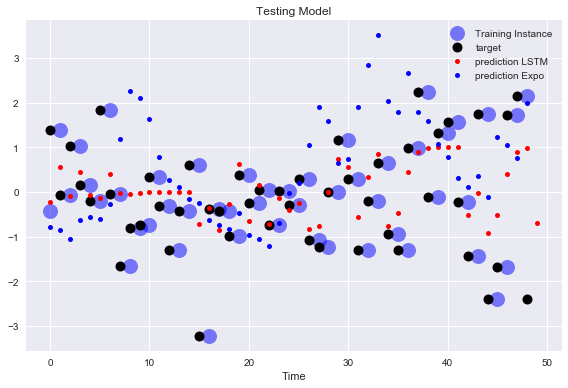

In [423]:
for i in range(0,10):
    showOtherGraph()

In [25]:
import tensorflow as tf
if 'session' in locals() and session is not None:
    print('Close interactive session')
    session.close()
tf.reset_default_graph()

# With Other Variables !


In [26]:
def extractInterestingData(nbOfDataPoints_, aOptionStrike,data_):
    myTicksOfInterest = np.empty(shape = (0,0))
    myCounter = 0
    myLastVol = 0
    myLastVolFut = 0
    timeOfTradeFut = 0
    
    myFirstFut = True
    myFirstOpt = True
    myFutBook = ''
    myOptionBook = ''
    
    for idx, tick in enumerate(data_):
        myBook =tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
            if tick['type']=='lastdone' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE: 
                
                if myFirstFut:
                    myFutBook = myBook
                    myFirstFut = False
                    
                if myFutBook == myBook:
                    myLastVolFut = (0.995*myLastVol + 0.001*(tick['volume']))
                    timeOfTradeFut = datetime.utcfromtimestamp(tick['created']/1000000)
        
            if tick['type']=='lastdone' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
                    
                    if myFirstOpt:
                        myOptionBook = myBook
                        myFirstOpt = False
                    
                    if myOptionBook == myBook:   
                        myLastVol = (0.995*myLastVol + 0.001*(tick['volume']))
                        timeOfTrade = datetime.utcfromtimestamp(tick['created']/1000000)
                    
            if tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
                    
                    if myFirstOpt:
                        myOptionBook = myBook
                        myFirstOpt = False
                    
                    if myOptionBook == myBook:
                        myCounter = myCounter + 1
                        try:

                            currTime = datetime.utcfromtimestamp(tick['created']/1000000)
                            if len(myTicksOfInterest) == 0 :
                                myTicksOfInterest = np.array([ np.log((currTime-oldTime).microseconds/1000), \
                                                              15*myLastVol*np.exp(-(currTime-timeOfTrade).microseconds/1000) , \
                                                              20*myLastVolFut*np.exp(-(currTime-timeOfTradeFut).microseconds/1000) ])
                            else:
                                myTicksOfInterest = np.vstack( (myTicksOfInterest,np.array([ np.log((currTime-oldTime).microseconds/1000), \
                                                                                            15*myLastVol*np.exp(-(currTime-timeOfTrade).microseconds/1000), \
                                                                                            20*myLastVolFut*np.exp(-(currTime-timeOfTradeFut).microseconds/1000) ])) )

                        except Exception as e:
                            print(e)
                            pass #pass, not continue, continue switch to the next itirqtion
                        oldTime = datetime.utcfromtimestamp(tick['created']/1000000)
                    
        if myCounter > nbOfDataPoints_:
            break
    return myTicksOfInterest

def whichStrikeAtMoney(data_):
    for idx, tick in enumerate(data_):
        myBook = tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
            if tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE: 
#                 print(tick)
                return int(5 * np.floor((tick['bid_price_0']+ tick['ask_price_0'])/2/5))

In [27]:
WaitingTimeAndTrade = extractInterestingData(40000,whichStrikeAtMoney(data),data)

local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
unsupported operand type(s) for -: 'datetime.datetime' and 'int'


In [28]:
len(WaitingTimeAndTrade)

39996

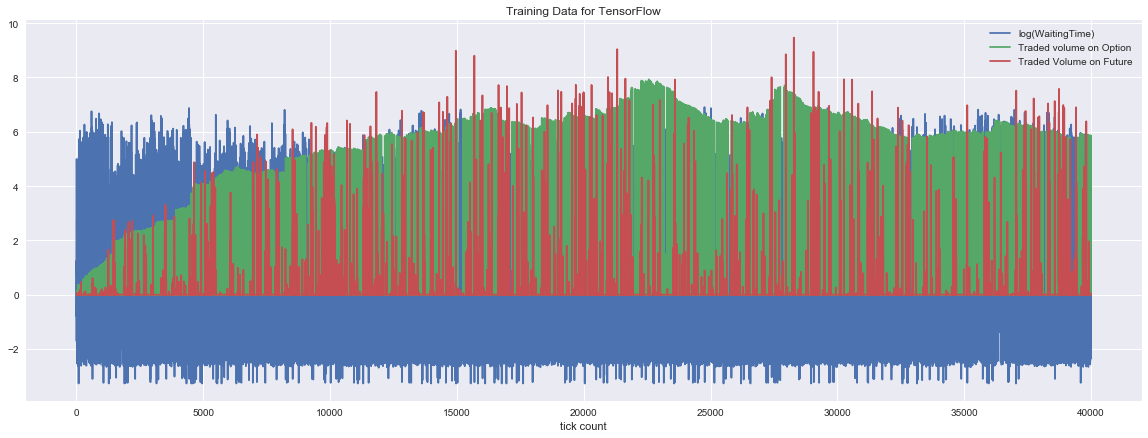

In [29]:
plt.figure(figsize=(20,7))
plt.title('Training Data for TensorFlow')
plt.plot(WaitingTimeAndTrade)
plt.legend(['log(WaitingTime)','Traded volume on Option','Traded Volume on Future'])
plt.xlabel('tick count')
plt.show()

In [30]:
tf.reset_default_graph()

In [31]:
# Just one feature, the time series
num_inputs = 3
# 100 neuron layer, play with this
num_neurons = 200
# Just one output, predicted time series
num_outputs = 1
# learning rate, 0.0001 default, but you can play with this
learning_rate = 0.00005
# how many iterations to go through (training steps), you can play with this
num_train_iterations = 60000
# Size of the batch of data
batch_size = 500

# Num of steps in batch (also used for prediction steps into the future)
num_time_steps = 50


X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])



In [32]:
tf.all_variables()

Instructions for updating:
Please use tf.global_variables instead.


[]

In [33]:

# cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu)

with tf.name_scope("LSTMcells2"):
    n_layers = 4
    lstmCells = [tf.contrib.rnn.LSTMCell(num_units=500, state_is_tuple=True, forget_bias=0.5,reuse=tf.get_variable_scope().reuse)]
    lstmCells.extend([tf.contrib.rnn.LSTMCell(num_units=num_neurons, state_is_tuple=True,reuse=tf.get_variable_scope().reuse)
          for layer in range(n_layers-1)])
    myLstmForDrop = tf.contrib.rnn.LSTMCell(num_units=num_neurons, state_is_tuple=True,reuse=tf.get_variable_scope().reuse)
    lstmCells.append(tf.contrib.rnn.DropoutWrapper(cell=myLstmForDrop, output_keep_prob=0.8))

    cell = tf.contrib.rnn.MultiRNNCell(lstmCells)
    outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    
    
with tf.variable_scope("LSTM_V2") as vs:
    lstm_variables = []
    for v in tf.all_variables():
        if v.name.startswith("rnn/multi_rnn_cell/"):
#             print(v)
            lstm_variables.append(v)
    for v in lstm_variables:
        tf.summary.histogram(str(v), v)
tf.initialize_variables(lstm_variables)


with tf.name_scope("loss2"):
    loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
    tf.summary.scalar('loss', loss)
with tf.name_scope("train2"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train = optimizer.minimize(loss)

init = tf.global_variables_initializer()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)
saver = tf.train.Saver()


Instructions for updating:
Please use tf.global_variables instead.
INFO:tensorflow:Summary name <tf.Variable 'rnn/multi_rnn_cell/cell_0/lstm_cell/weights:0' shape=(503, 2000) dtype=float32_ref> is illegal; using _tf.Variable__rnn/multi_rnn_cell/cell_0/lstm_cell/weights_0__shape__503__2000__dtype_float32_ref_ instead.
INFO:tensorflow:Summary name <tf.Variable 'rnn/multi_rnn_cell/cell_0/lstm_cell/biases:0' shape=(2000,) dtype=float32_ref> is illegal; using _tf.Variable__rnn/multi_rnn_cell/cell_0/lstm_cell/biases_0__shape__2000___dtype_float32_ref_ instead.
INFO:tensorflow:Summary name <tf.Variable 'rnn/multi_rnn_cell/cell_1/lstm_cell/weights:0' shape=(700, 800) dtype=float32_ref> is illegal; using _tf.Variable__rnn/multi_rnn_cell/cell_1/lstm_cell/weights_0__shape__700__800__dtype_float32_ref_ instead.
INFO:tensorflow:Summary name <tf.Variable 'rnn/multi_rnn_cell/cell_1/lstm_cell/biases:0' shape=(800,) dtype=float32_ref> is illegal; using _tf.Variable__rnn/multi_rnn_cell/cell_1/lstm_cell/

In [34]:
def next_batch(data,batch_size,steps,return_index=False):
    nbLabels = data.shape[1]
    # Grab a random starting point for each batch
    rand_start = rand_start = np.random.randint(len(data)-steps, size=(batch_size,1), dtype = 'int32') #int16 might not be enough

    # Create batch Time Series on occurences (t)
    batch_indices = rand_start + np.arange(0,steps+1)
    
    x_batch = data[batch_indices]
    
    
    # Format for RNN
    if return_index:
        return x_batch[:, :-1, :].reshape(batch_size, steps, nbLabels), x_batch[:, 1:, :1].reshape(batch_size, steps, 1) ,batch_indices

    else:
        return x_batch[:, :-1, :].reshape(batch_size, steps, nbLabels), x_batch[:, 1:, :1].reshape(batch_size, steps, 1)

In [ ]:
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    sess.run(init)
    tf.summary.FileWriterCache.clear()
    merged_summary = tf.summary.merge_all()
    writer = tf.summary.FileWriter('C:\\Users\\Hal9000-ti\\ML_MiniProjects\\onlyWaitingTime\\11',graph = sess.graph)  # create writer

        

    for iteration in range(num_train_iterations):
        
        X_batch, y_batch = next_batch(WaitingTimeAndTrade, batch_size, num_time_steps)

        if iteration % 50 == 0:   
            s = sess.run(merged_summary, feed_dict={X: X_batch, y: y_batch})
            writer.add_summary(s,iteration)
        if iteration % 500 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
        sess.run(train, feed_dict={X: X_batch, y: y_batch})
       
    
    # Save Model for Later
    saver.save(sess, "./rnn_time_series_model")

0 	MSE: 4.52347
500 	MSE: 3.9223
1000 	MSE: 3.76206
1500 	MSE: 3.83137
2000 	MSE: 3.79835
2500 	MSE: 3.74854
3000 	MSE: 3.61283
3500 	MSE: 3.51345
4000 	MSE: 3.55486
4500 	MSE: 3.41932
5000 	MSE: 3.55586
5500 	MSE: 3.4759
6000 	MSE: 3.49912
6500 	MSE: 3.52444
7000 	MSE: 3.48834
7500 	MSE: 3.4046
8000 	MSE: 3.34053
8500 	MSE: 3.34665
9000 	MSE: 3.48596
9500 	MSE: 3.32696
10000 	MSE: 3.49343
10500 	MSE: 3.35108
11000 	MSE: 3.35121
11500 	MSE: 3.27782
12000 	MSE: 3.1645
12500 	MSE: 3.37829
13000 	MSE: 3.25674
13500 	MSE: 3.43578
14000 	MSE: 3.22755
14500 	MSE: 3.24063
15000 	MSE: 3.26115
15500 	MSE: 3.17531
16000 	MSE: 3.08009
16500 	MSE: 3.16789
17000 	MSE: 3.27803
17500 	MSE: 3.28609
18000 	MSE: 3.15627
18500 	MSE: 3.06413
19000 	MSE: 3.32424
19500 	MSE: 3.19217
20000 	MSE: 3.16297
20500 	MSE: 3.1276
21000 	MSE: 3.19157
21500 	MSE: 3.15346
22000 	MSE: 3.07589
22500 	MSE: 3.1919
23000 	MSE: 3.12279
23500 	MSE: 2.97085
24000 	MSE: 2.98262
24500 	MSE: 3.20102
25000 	MSE: 3.09786
25500 	MSE

In [36]:
WaitingTimeAndTrade[:,0]

array([ 0.72124861, -0.50583808,  1.24760684, ..., -0.92886951,
        0.72561437,  1.1239551 ])

In [37]:
def residualExpoMovingAverage(aParam) : 
    errs = []
    first = True
    counter = 0
    for idx, waitingTime in enumerate(WaitingTimeAndTrade[:,0]):
            counter = counter + 1
            if not first:
                errs.append((waitingTime - ExpectedTime)*(waitingTime - ExpectedTime))
                ExpectedTime = aParam*ExpectedTime +(1-aParam)*waitingTime
            else:
                if counter  > 2:
                    ExpectedTime = waitingTime
                    first = False
            
    return np.mean(errs[1:])

res_bench2 = optimize.minimize(residualExpoMovingAverage,[1], method='SLSQP', options={'maxiter':30000})
print(res_bench2.fun)

def returnPred(aParam) : 
    pred = []
    first = True
    counter = 0
    ExpectedTime = 0
    for idx, waitingTime in enumerate(WaitingTimeAndTrade[:,0][startTime:startTime+num_time_steps][:-1]):

                ExpectedTime = aParam*ExpectedTime +(1-aParam)*waitingTime

                pred.append(ExpectedTime)
            
    return pred


C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in multiply
  
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':


3.4928180133771454


In [38]:
WaitingTimeAndTrade[startTime:startTime+num_time_steps,:1]

array([[ 4.11978486],
       [ 0.35767444],
       [ 0.12663265],
       [ 4.01374892],
       [-1.95899539],
       [ 3.55563373],
       [ 0.64185389],
       [-0.35239839],
       [ 0.6408007 ],
       [ 0.69364706],
       [ 4.71779327],
       [ 2.39771344],
       [ 3.74144818],
       [ 0.52472853],
       [-1.77785656],
       [ 1.47613507],
       [-1.52785793],
       [ 0.89853401],
       [ 1.19240617],
       [-0.37542099]])

In [39]:
def showOtherGraph2():
    startTime = np.random.randint(len(WaitingTimeAndTrade)-num_time_steps,size=())
    nbLabels = WaitingTimeAndTrade.shape[1]
    with tf.Session() as sess:                          
        saver.restore(sess, "./rnn_time_series_model")   
        X_new = np.array(WaitingTimeAndTrade[startTime:startTime+num_time_steps].reshape(-1, num_time_steps, nbLabels))
        y_pred = sess.run(outputs, feed_dict={X: X_new})

    plt.title("Testing Model")

    # Training Instance
    plt.plot(WaitingTimeAndTrade[startTime:startTime+num_time_steps,:1][:-1], "bo", markersize=15,alpha=0.5, label="Training Instance")

    # Target to Predict
    plt.plot(WaitingTimeAndTrade[startTime:startTime+num_time_steps,:1][1:], "ko", markersize=10, label="target")

    # Models Prediction
    plt.plot(y_pred[0,:,0][:-1], "r.", markersize=10, label="prediction LSTM")

    plt.plot(returnPred(res_bench2.x), "b.", markersize=10, label="prediction Expo")
    plt.xlabel("Time")
    plt.legend()
    plt.tight_layout()
    plt.show()

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


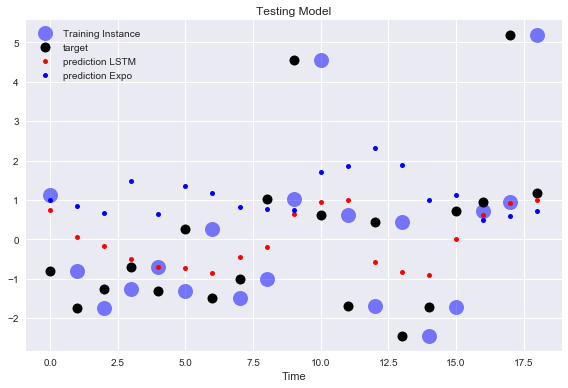

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


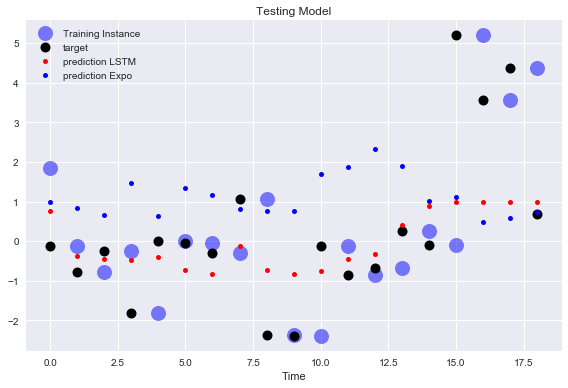

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


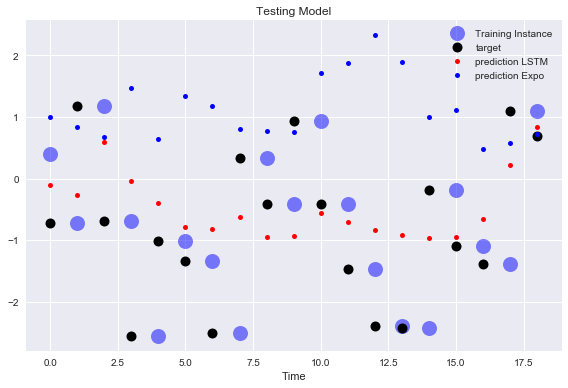

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


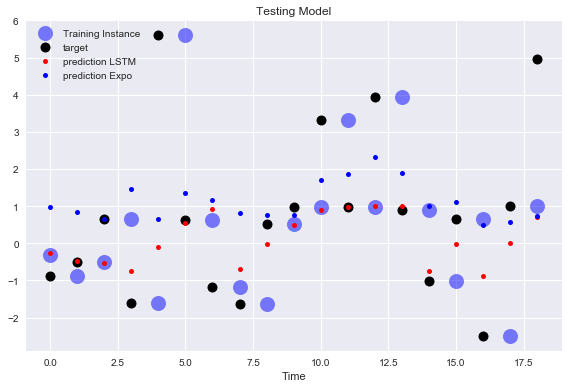

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


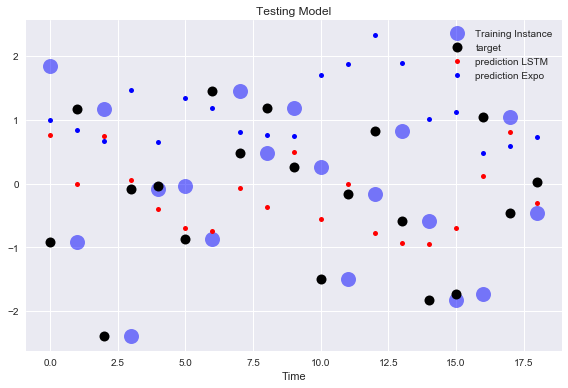

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


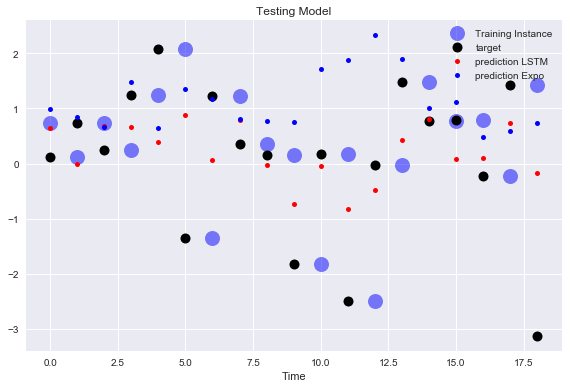

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


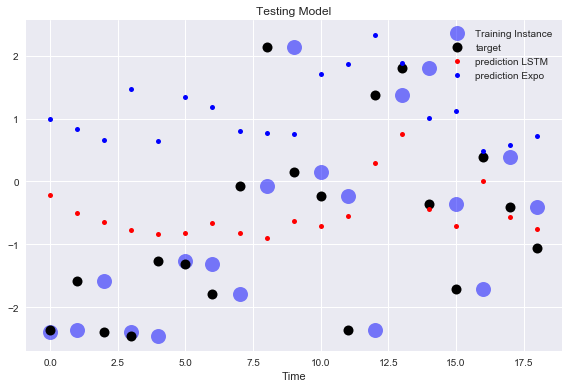

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


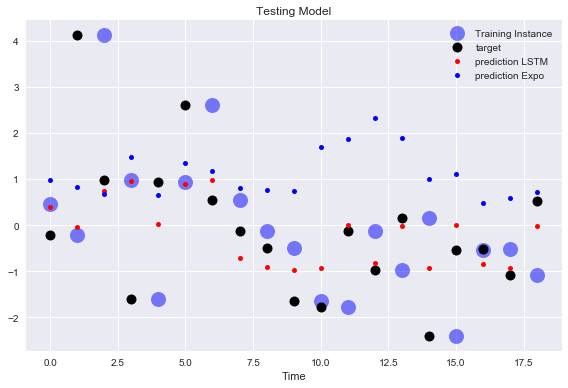

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


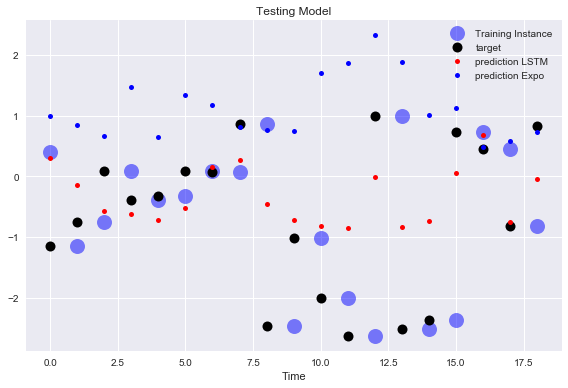

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model


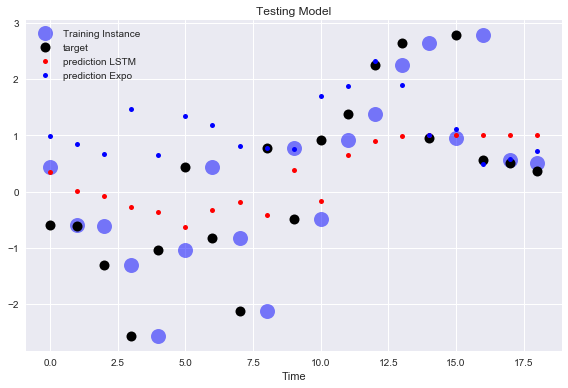

In [40]:
for i in range(0,10):
    showOtherGraph2()

In [41]:
# tf.reset_default_graph()

In [42]:
#after reviewing the data: the problem seems to be the shocks. When they occur, they create a huge shock on the MLS estimator, forcing it to adjust to this shock more than to fit the remaining of the data

In [43]:
# # Just one feature, the time series
# num_inputs = 3
# # 100 neuron layer, play with this
# num_neurons = 100
# # Just one output, predicted time series
# num_outputs = 1
# # learning rate, 0.0001 default, but you can play with this
# learning_rate = 0.0005
# # how many iterations to go through (training steps), you can play with this
# num_train_iterations = 25000
# # Size of the batch of data
# batch_size = 1300

# # Num of steps in batch (also used for prediction steps into the future)
# num_time_steps = 20


# X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
# y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])


# # cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu)

# n_layers = 3

# cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons)
#           for layer in range(n_layers)])

# outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

# loss = tf.reduce_mean(tf.abs(outputs - y)) # MSE
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# train = optimizer.minimize(loss)

# init = tf.global_variables_initializer()
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)
# saver = tf.train.Saver()

In [44]:
# with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
#     sess.run(init)
    
#     for iteration in range(num_train_iterations):
        
#         X_batch, y_batch = next_batch(WaitingTimeAndTrade, batch_size, num_time_steps)
#         sess.run(train, feed_dict={X: X_batch, y: y_batch})
        
#         if iteration % 500 == 0:
            
#             ase = loss.eval(feed_dict={X: X_batch, y: y_batch})
#             print(iteration, "\tASE:", ase)
    
#     # Save Model for Later
#     saver.save(sess, "./rnn_time_series_model")

In [45]:
# def residualExpoMovingAverageABS(aParam) : 
#     errs = []
#     first = True
#     counter = 0
#     for idx, waitingTime in enumerate(WaitingTimeAndTrade[:,0]):
#             counter = counter + 1
#             if not first:
#                 errs.append(np.abs(waitingTime - ExpectedTime))
#                 ExpectedTime = aParam*ExpectedTime +(1-aParam)*waitingTime
#             else:
#                 if counter  > 2:
#                     ExpectedTime = waitingTime
#                     first = False
            
#     return np.mean(errs[1:])

# res_bench2 = optimize.minimize(residualExpoMovingAverageABS,[1], method='SLSQP', options={'maxiter':30000})
# print(res_bench2.fun)

In [46]:
# for i in range(0,10):
#     showOtherGraph2()

In [47]:

WaitingTimeAndTrade_test = extractInterestingData(30000,whichStrikeAtMoney(data),data)

local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
unsupported operand type(s) for -: 'datetime.datetime' and 'int'


In [48]:
# def residualExpoMovingAverageABS_testingSet(aParam) : 
#     errs = []
#     first = True
#     counter = 0
#     for idx, waitingTime in enumerate(WaitingTimeAndTrade_test[:,0]):
#             counter = counter + 1
#             if not first:
#                 errs.append(np.abs(waitingTime - ExpectedTime))
#                 ExpectedTime = aParam*ExpectedTime +(1-aParam)*waitingTime
#             else:
#                 if counter  > 2:
#                     ExpectedTime = waitingTime
#                     first = False
            
#     return np.mean(errs[1:])

# res_bench2_test = optimize.minimize(residualExpoMovingAverageABS_testingSet,[1], method='SLSQP', options={'maxiter':30000})
# print(res_bench2_test.fun)


# def returnPred_test(aParam) : 
#     pred = []
#     first = True
#     counter = 0
#     ExpectedTime = 0
#     for idx, waitingTime in enumerate(WaitingTimeAndTrade_test[:,0][startTime:startTime+num_time_steps][:-1]):

#                 ExpectedTime = aParam*ExpectedTime +(1-aParam)*waitingTime

#                 pred.append(ExpectedTime)
            
#     return pred


In [49]:
# def showOtherGraph_test():
#     startTime = np.random.randint(len(WaitingTimeAndTrade_test)-num_time_steps,size=())
#     nbLabels = WaitingTimeAndTrade_test.shape[1]
#     with tf.Session() as sess:                          
#         saver.restore(sess, "./rnn_time_series_model")   
#         X_new = np.array(WaitingTimeAndTrade_test[startTime:startTime+num_time_steps, :].reshape(-1, num_time_steps, nbLabels))
#         y_pred = sess.run(outputs, feed_dict={X: X_new})
        
#     print(np.average(np.abs(y_pred[0,:,0][:-1]-WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0])))
#     print(np.average(np.abs(returnPred_test(res_bench2_test.x) - WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0])))    
# #     plt.title("Testing Model")

# #     # Training Instance
# #     plt.plot(WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][:-1], "bo", markersize=15,alpha=0.5, label="Training Instance")

# #     # Target to Predict
# #     plt.plot(WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:], "ko", markersize=10, label="target")

# #     # Models Prediction
# #     plt.plot(y_pred[0,:,0][:-1], "r.", markersize=10, label="prediction LSTM")

# #     plt.plot(returnPred_test(res_bench2_test.x), "b.", markersize=10, label="prediction Expo")
# #     plt.xlabel("Time")
# #     plt.legend()
# #     plt.tight_layout()
# #     plt.show()
    
#     return np.average(np.abs(y_pred[0,:,0][:-1]-WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0])) ,\
#             np.average(np.abs(returnPred_test(res_bench2_test.x) - WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0]))

In [50]:
# error_lstm_dist = np.empty(shape = (0,0))
# error_expo_dist = np.empty(shape = (0,0))
# for i in range(0,200):
#     error_lstm, error_expo = showOtherGraph_test()
#     error_lstm_dist= np.append(error_lstm_dist,error_lstm)
#     error_expo_dist = np.append(error_expo_dist,error_expo)

In [51]:
# plt.style.use('seaborn')
# df_testRest = pd.DataFrame(data = np.column_stack([error_lstm_dist,error_expo_dist]), columns=['error_lstm_distribution', "error_expo_distribution"])



# df_testRest.plot.hist(alpha = 0.5, bins=30,figsize=(15,6))
# plt.xlabel('Error')
# plt.ylabel('Occurence')
# plt.legend()
# plt.show()

In [52]:
# df_testRest.describe()

In [53]:
#now completely different dataset : 

In [54]:
# with gzip.open('data\\2017.10.12\\feeddata_10.json.gz', "rb") as f:
#     data = json.loads(f.read().decode("ascii"))
WaitingTimeAndTrade_test = extractInterestingData(30000,whichStrikeAtMoney(data),data)

local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
unsupported operand type(s) for -: 'datetime.datetime' and 'int'


In [55]:
# WaitingTimeAndTrade_test = extractInterestingData(30000,whichStrikeAtMoney(data),data)

In [56]:
# def residualExpoMovingAverageABS_testingSet(aParam) : 
#     errs = []
#     first = True
#     counter = 0
#     for idx, waitingTime in enumerate(WaitingTimeAndTrade_test[:,0]):
#             counter = counter + 1
#             if not first:
#                 errs.append(np.abs(waitingTime - ExpectedTime))
#                 ExpectedTime = aParam*ExpectedTime +(1-aParam)*waitingTime
#             else:
#                 if counter  > 2:
#                     ExpectedTime = waitingTime
#                     first = False
            
#     return np.mean(errs[1:])

# # res_bench2_test = optimize.minimize(residualExpoMovingAverageABS_testingSet,[1], method='SLSQP', options={'maxiter':30000})
# # print(res_bench2_test.fun)


# def returnPred_test(aParam) : 
#     pred = []
#     first = True
#     counter = 0
#     ExpectedTime = 0
#     for idx, waitingTime in enumerate(WaitingTimeAndTrade_test[:,0][startTime:startTime+num_time_steps][:-1]):

#                 ExpectWaitingTimeAndTrade_testedTime = aParam*ExpectedTime +(1-aParam)*waitingTime

#                 pred.append(ExpectedTime)
            
#     return pred


In [57]:
# error_lstm_dist = np.empty(shape = (0,0))
# error_expo_dist = np.empty(shape = (0,0))
# for i in range(0,200):
#     error_lstm, error_expo = showOtherGraph_test()
#     error_lstm_dist= np.append(error_lstm_dist,error_lstm)
#     error_expo_dist = np.append(error_expo_dist,error_expo)

In [58]:
# #the expo hasn() been fitted to the new data:

# plt.style.use('seaborn')
# df_testRest = pd.DataFrame(data = np.column_stack([error_lstm_dist,error_expo_dist]), columns=['error_lstm_distribution', "error_expo_distribution"])



# df_testRest.plot.hist(alpha = 0.5, bins=30,figsize=(15,6))
# plt.xlabel('Error')
# plt.ylabel('Occurence')
# plt.legend()
# plt.show()

In [59]:
# res_bench2_test = optimize.minimize(residualExpoMovingAverageABS_testingSet,[1], method='SLSQP', options={'maxiter':30000})
# print(res_bench2_test.fun)
# #the expo has been fitted to the new data:
# error_lstm_dist = np.empty(shape = (0,0))
# error_expo_dist = np.empty(shape = (0,0))
# for i in range(0,200):
#     error_lstm, error_expo = showOtherGraph_test()
#     error_lstm_dist= np.append(error_lstm_dist,error_lstm)
#     error_expo_dist = np.append(error_expo_dist,error_expo)

In [60]:
# #the expo hasn been fitted to the new data:

# plt.style.use('seaborn')
# df_testRest = pd.DataFrame(data = np.column_stack([error_lstm_dist,error_expo_dist]), columns=['error_lstm_distribution', "error_expo_distribution"])



# df_testRest.plot.hist(alpha = 0.5, bins=30,figsize=(15,6))
# plt.xlabel('Error')
# plt.ylabel('Occurence')
# plt.legend()
# plt.show()

In [61]:
# with gzip.open('data\\2017.10.20\\feeddata_12.json.gz', "rb") as f:
#     data = json.loads(f.read().decode("ascii"))
    
# WaitingTimeAndTrade_test = extractInterestingData(30000,whichStrikeAtMoney(data),data)

# error_lstm_dist = np.empty(shape = (0,0))
# error_expo_dist = np.empty(shape = (0,0))
# for i in range(0,2000):
#     error_lstm, error_expo = showOtherGraph_test()
#     error_lstm_dist= np.append(error_lstm_dist,error_lstm)
#     error_expo_dist = np.append(error_expo_dist,error_expo)
    


In [62]:
# plt.style.use('seaborn')
# df_testRest = pd.DataFrame(data = np.column_stack([error_lstm_dist,error_expo_dist]), columns=['error_lstm_distribution', "error_expo_distribution"])



# df_testRest.plot.hist(alpha = 0.5, bins=70,figsize=(15,6))
# plt.xlabel('Error')
# plt.ylabel('Occurence')
# plt.legend()
# plt.show()

In [63]:
# df_testRest.describe()

In [64]:
def returnPred_test(aParam,startTime) : 
    pred = []
    first = True
    counter = 0
    ExpectedTime = 0
    for idx, waitingTime in enumerate(WaitingTimeAndTrade_test[:,0][startTime-10:startTime+num_time_steps][:-1]):

                ExpectWaitingTimeAndTrade_testedTime = aParam*ExpectedTime +(1-aParam)*waitingTime
                if idx>9:
                    pred.append(ExpectedTime)
            
    return pred

In [65]:
#exactly the same, same params, just take squared errors

def showOtherGraph_squared():
    startTime = np.random.randint(len(WaitingTimeAndTrade_test)-num_time_steps-10,size=())+10
    nbLabels = WaitingTimeAndTrade_test.shape[1]
    with tf.Session() as sess:                          
        saver.restore(sess, "./rnn_time_series_model")   
        X_new = np.array(WaitingTimeAndTrade_test[startTime:startTime+num_time_steps, :].reshape(-1, num_time_steps, nbLabels))
        y_pred = sess.run(outputs, feed_dict={X: X_new})
        
#     print(np.average(np.square(y_pred[0,:,0][:-1]-WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0])))
#     print(np.average(np.square(returnPred_test(res_bench2_test.x,startTime) - WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0])))    
#     plt.title("Testing Model")

#     # Training Instance
#     plt.plot(WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][:-1], "bo", markersize=15,alpha=0.5, label="Training Instance")

#     # Target to Predict
#     plt.plot(WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:], "ko", markersize=10, label="target")

#     # Models Prediction
#     plt.plot(y_pred[0,:,0][:-1], "r.", markersize=10, label="prediction LSTM")

#     plt.plot(returnPred_test(res_bench2_test.x), "b.", markersize=10, label="prediction Expo")
#     plt.xlabel("Time")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()
    
    return np.average(np.square(y_pred[0,:,0][:-1]-WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0])) ,\
            np.average(np.square(returnPred_test(res_bench2.x,startTime) - WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0]))

In [66]:

WaitingTimeAndTrade_test = WaitingTimeAndTrade
error_lstm_dist = np.empty(shape = (0,0))
error_expo_dist = np.empty(shape = (0,0))
for i in range(0,2000):
    error_lstm, error_expo = showOtherGraph_squared()
    error_lstm_dist= np.append(error_lstm_dist,error_lstm)
    error_expo_dist = np.append(error_expo_dist,error_expo)
    

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

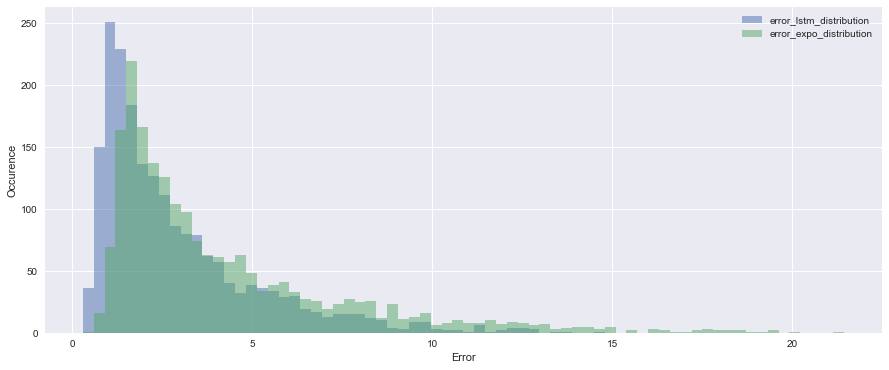

,error_lstm_distribution,error_expo_distribution
count,2000.000000,2000.000000
mean,2.906975,4.199339
std,2.271494,3.316989
min,0.299389,0.540504
25%,1.292605,1.857564
50%,2.153462,3.003478
75%,3.751060,5.408859
max,14.524724,21.428301


In [67]:
plt.style.use('seaborn')
df_testRest = pd.DataFrame(data = np.column_stack([error_lstm_dist,error_expo_dist]), columns=['error_lstm_distribution', "error_expo_distribution"])



df_testRest.plot.hist(alpha = 0.5, bins=70,figsize=(15,6))
plt.xlabel('Error')
plt.ylabel('Occurence')
plt.legend()
plt.show()

df_testRest.describe()

In [68]:
#import new data!!!
with gzip.open('data\\2017.10.12\\feeddata_10.json.gz', "rb") as f:
    data = json.loads(f.read().decode("ascii"))
WaitingTimeAndTrade_test = extractInterestingData(30000,whichStrikeAtMoney(data),data)

local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' and 'int'
unsupported operand type(s) for -: 'datetime.datetime' 

In [69]:
#exactly the same, same params, just take squared errors

def showOtherGraph_test_squared():
    startTime = np.random.randint(len(WaitingTimeAndTrade_test)-num_time_steps,size=())
    nbLabels = WaitingTimeAndTrade_test.shape[1]
    with tf.Session() as sess:                          
        saver.restore(sess, "./rnn_time_series_model")   
        X_new = np.array(WaitingTimeAndTrade_test[startTime:startTime+num_time_steps, :].reshape(-1, num_time_steps, nbLabels))
        y_pred = sess.run(outputs, feed_dict={X: X_new})
        
#     print(np.average(np.square(y_pred[0,:,0][:-1]-WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0])))
#     print(np.average(np.square(returnPred_test(res_bench2_test.x,startTime) - WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0])))    
#     plt.title("Testing Model")

#     # Training Instance
#     plt.plot(WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][:-1], "bo", markersize=15,alpha=0.5, label="Training Instance")

#     # Target to Predict
#     plt.plot(WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:], "ko", markersize=10, label="target")

#     # Models Prediction
#     plt.plot(y_pred[0,:,0][:-1], "r.", markersize=10, label="prediction LSTM")

#     plt.plot(returnPred_test(res_bench2_test.x), "b.", markersize=10, label="prediction Expo")
#     plt.xlabel("Time")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()
    
    return np.average(np.square(y_pred[0,:,0][:-1]-WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0])) ,\
            np.average(np.square(returnPred_test(res_bench2.x,startTime) - WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0]))

In [70]:


error_lstm_dist_test = np.empty(shape = (0,0))
error_expo_dist_test = np.empty(shape = (0,0))
for i in range(0,2000):
    error_lstm, error_expo = showOtherGraph_test_squared()
    error_lstm_dist_test= np.append(error_lstm_dist_test,error_lstm)
    error_expo_dist_test = np.append(error_expo_dist_test,error_expo)

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tensorflow:Restoring parameters from ./rnn_time_series_model
INFO:tenso

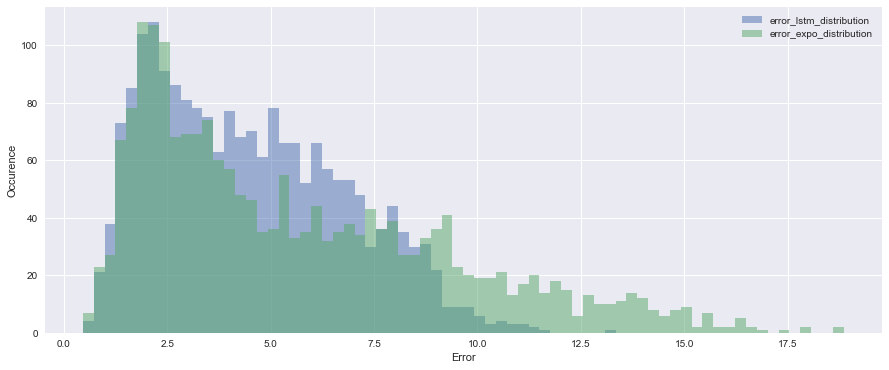

,error_lstm_distribution,error_expo_distribution
count,2000.000000,2000.000000
mean,4.497599,5.658833
std,2.321056,3.723028
min,0.582354,0.460482
25%,2.461216,2.516402
50%,4.193454,4.620062
75%,6.187460,8.063936
max,13.075956,18.854572


In [71]:
plt.style.use('seaborn')
df_testRest = pd.DataFrame(data = np.column_stack([error_lstm_dist_test,error_expo_dist_test]), columns=['error_lstm_distribution', "error_expo_distribution"])



df_testRest.plot.hist(alpha = 0.5, bins=70,figsize=(15,6))
plt.xlabel('Error')
plt.ylabel('Occurence')
plt.legend()
plt.show()

df_testRest.describe()

In [72]:
# #New session try:

# def residualExpoMovingAverageSQ_testingSet(aParam) : 
#     errs = []
#     first = True
#     counter = 0
#     for idx, waitingTime in enumerate(WaitingTimeAndTrade_test[:,0]):
#             counter = counter + 1
#             if not first:
#                 errs.append(np.abs(waitingTime - ExpectedTime))
#                 ExpectedTime = aParam*ExpectedTime +(1-aParam)*waitingTime
#             else:
#                 if counter  > 2:
#                     ExpectedTime = waitingTime
#                     first = False
            
#     return np.mean(errs[1:])


# def returnPred_test(aParam,startTime) : 
#     pred = []
#     first = True
#     counter = 0
#     ExpectedTime = 0
#     for idx, waitingTime in enumerate(WaitingTimeAndTrade_test[:,0][startTime:startTime+num_time_steps][:-1]):

#                 ExpectedTime = aParam*ExpectedTime +(1-aParam)*waitingTime

#                 pred.append(ExpectedTime)
            
#     return pred


In [73]:

def test_squared(n_iteration):
   
    error_lstm_dist = np.empty(shape = (0,0))
    error_expo_dist = np.empty(shape = (0,0))
    
    with tf.Session() as sess:                          
        saver.restore(sess, "./rnn_time_series_model") 
        for i in range(0,n_iteration):
            startTime = np.random.randint(len(WaitingTimeAndTrade_test)-num_time_steps,size=())
            nbLabels = WaitingTimeAndTrade_test.shape[1]
            X_new = np.array(WaitingTimeAndTrade_test[startTime:startTime+num_time_steps, :].reshape(-1, num_time_steps, nbLabels))
            y_pred = sess.run(outputs, feed_dict={X: X_new})
            error_lstm, error_expo = np.average(np.square(y_pred[0,:,0][:-1]-WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0])) ,\
                np.average(np.square(returnPred_test(res_bench2.x,startTime) - WaitingTimeAndTrade_test[startTime:startTime+num_time_steps,:1][1:].T[0]))
            error_lstm_dist= np.append(error_lstm_dist,error_lstm)
            error_expo_dist = np.append(error_expo_dist,error_expo)

    return pd.DataFrame(data = np.column_stack([error_lstm_dist,error_expo_dist]), columns=['error_lstm_distribution', "error_expo_distribution"])

In [74]:
# with gzip.open('data\\2017.10.16\\feeddata_10.json.gz', "rb") as f: #same set as tf model
#     data = json.loads(f.read().decode("ascii"))
# WaitingTimeAndTrade_test = extractInterestingData(30000,whichStrikeAtMoney(data),data)
# res_bench2_test = optimize.minimize(residualExpoMovingAverageSQ_testingSet,[1], method='SLSQP', options={'maxiter':30000})

# #Apply Chi-square distance on a new test :
# with gzip.open('data\\2017.10.12\\feeddata_10.json.gz', "rb") as f:
#     data = json.loads(f.read().decode("ascii"))
    
# WaitingTimeAndTrade_test = extractInterestingData(30000,whichStrikeAtMoney(data),data)


In [75]:
# df_testRest = test_squared(10000)

In [76]:
# plt.style.use('seaborn')

# df_testRest.plot.hist(alpha = 0.5, bins=70,figsize=(15,6))
# plt.xlabel('Error')
# plt.ylabel('Occurence')
# plt.legend()
# plt.show()

# df_testRest.describe()

In [77]:
from scipy.stats import ks_2samp
# ks_2samp(df_testRest['error_lstm_distribution'], df_testRest['error_expo_distribution'])

In [78]:
#just to be really sure :

In [79]:
Stat = np.empty(shape = (0,0))
AverageExpo = np.empty(shape = (0,0))
AverageLSTM = np.empty(shape = (0,0))
STDExpo = np.empty(shape = (0,0))
STDLSTM = np.empty(shape = (0,0))
PValue = np.empty(shape = (0,0))

for i in range(1,30):
    for j in range(10,14):
        if i<10:
            myDay = "0"+str(i)
        else:
            myDay = str(i)
        myFile = Path('data\\2017.10.'+myDay+'\\feeddata_'+str(j)+'.json.gz')
        if myFile.exists():
            with gzip.open(myFile, "rb") as f:
                data = json.loads(f.read().decode("ascii"))

            WaitingTimeAndTrade_test = extractInterestingData(50000,whichStrikeAtMoney(data),data)
            df_testRest = test_squared(5000)
            Kolmo = ks_2samp(df_testRest['error_lstm_distribution'], df_testRest['error_expo_distribution'])
            Stat = np.append(Stat,Kolmo.statistic)
            PValue = np.append(PValue,Kolmo.pvalue)
            
            AverageExpo = np.append(AverageExpo,df_testRest['error_expo_distribution'].mean())
            AverageLSTM = np.append(AverageLSTM,df_testRest['error_lstm_distribution'].mean())
            STDExpo = np.append(STDExpo,df_testRest['error_expo_distribution'].std())
            STDLSTM = np.append(STDLSTM,df_testRest['error_lstm_distribution'].std())
            
KolmoDF = pd.DataFrame(data = np.column_stack([AverageLSTM, AverageExpo,STDLSTM,STDExpo, Stat,PValue]), columns=['Average Accuracy LSTM','Average Accuracy Expo','Std Accuracy LSTM','Std Accuracy Expo','Statistic', "Pvalue"])        


local variable 'oldTime' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'timeOfTrade' referenced before assignment
local variable 'ti

ValueError: operands could not be broadcast together with shapes (0,) (19,) 

In [ ]:
KolmoDF.describe()

In [ ]:
KolmoDF.drop("Std Accuracy LSTM",axis=1).drop("Std Accuracy Expo",axis=1).drop("Statistic",axis=1).drop("Pvalue",axis=1).plot.hist(alpha = 0.5, bins=10,figsize=(15,6))
plt.xlabel("Squared Errors")
plt.show()

In [ ]:
KolmoDF.drop("Average Accuracy LSTM",axis=1).drop("Average Accuracy Expo",axis=1).drop("Statistic",axis=1).drop("Pvalue",axis=1).plot.hist(alpha = 0.5, bins=10,figsize=(15,6))
plt.xlabel("Std of Squared Errors")
plt.show()

In [ ]:
KolmoDF.drop("Std Accuracy LSTM",axis=1).drop("Std Accuracy Expo",axis=1).drop("Average Accuracy LSTM",axis=1).drop("Average Accuracy Expo",axis=1).drop("Statistic",axis=1).plot.hist(alpha = 0.5, bins=10,figsize=(15,6))
plt.xlabel("P-Value of Kolmogorov-Smirnov Test")
plt.show()